<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Fin de Máster</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Autor: César Fernández Domínguez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Evaluación de modelos de predicción de contaminación del aire para la ciudad de Barcelona

Este análisis se ha organizado en los siguientes apartados:

 <ol start="1">
  <li>Carga de datos</li>
  <li>Definición de modelos
  <br>2.1. Modelo de regresión de bosques aleatorios (Random Forest - RF) 
  <br>2.2. Modelo de regresión de máquina de vectores de soporte (Support Vector Machine - SVM) 
  <br>2.3. Modelo de regresión mediante red neuronal perceptrón de multicapa (MultiLayer Perceptron - MLP) 
  <br>2.4. Modelo de regresión mediante una red neuronal recurrente Long Short-Term Memory (LSTM) 
  <br>2.5. Modelo de regresión mediante una red neuronal recurrente a base de Gated Recurrent Units (GRU)
  <li>Ejecución de modelos
  <li>Presentación y análisis de resultados
  <br>4.1. Resultados para la predicción del Óxido de Carbono ( $CO$ )
  <br>4.2. Resultados para la predicción del Óxido de Nitrógeno ( $NO_x$ )
  <br>4.3. Resultados para la predicción del Dióxido de Nitrógeno ( $NO_2$ )
  <br>4.4. Resultados para la predicción del Ozono ( $O_3$ )
  <li>Evaluación de datos de entrada
  <br>5.1. Resultados para la predicción del Óxido de Carbono ( $CO$ )
  <br>5.2. Resultados para la predicción del Óxido de Nitrógeno ( $NO_x$ )
  <br>5.3. Resultados para la predicción del Dióxido de Nitrógeno ( $NO_2$ )
  <br>5.4. Resultados para la predicción del Ozono ( $O_3$ )
  <li>Conclusiones
</ol>
   
En primer lugar, cargamos algunas librerías que vamos a necesitar, y definimos la carpeta raiz de donde cargaremos nuestros datos.

In [1]:
# Mount folder in Google Drive (only for execution in Google Colab)
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import sys, os
import numpy as np
import pandas as pd
import random

seed = 7
np.random.seed(seed)    

rootDataFolder="../data/"
#rootDataFolder="/content/drive/My Drive/colab/data/"

En este notebook, vamos a ejecutar cada uno de los modelos propuestos utilizando la mejor configuración obtenida en los notebooks anteriores. Finalmente, realizaremos una predicción para cada uno de los modelos y mostraremos los resultados. 

# 1. Carga de datos

Inicialmente, cargamos los datos de contaminantes registrados, datos meteorológicos y datos de tránsito de vehículos, que previamente hemos analizado y preparado.

In [3]:
# Read air data file
data_air_hourly = pd.read_csv(os.path.join(rootDataFolder, "data_air_hourly_red.csv"), sep=',', encoding = "UTF-8")
data_air_hourly=data_air_hourly.drop('PM10', axis=1)
data_air_hourly['DATA'] = pd.DatetimeIndex(data_air_hourly['DATA'])

# Read imputated air data file
data_air_hourly_imp = pd.read_csv(os.path.join(rootDataFolder, "data_air_hourly_imp.csv"), sep=',', encoding = "UTF-8")
data_air_hourly_imp=data_air_hourly_imp.drop('PM10', axis=1)
data_air_hourly_imp['DATA'] = pd.DatetimeIndex(data_air_hourly_imp['DATA'])

# Read air stations data file
data_air_stations = pd.read_csv(os.path.join(rootDataFolder, "data_air_stations.csv"), sep=',', encoding = "UTF-8")

# Read meteo data file
data_meteo_hourly = pd.read_csv(os.path.join(rootDataFolder, "data_meteo_hourly_red.csv"), sep=',', encoding = "UTF-8")
data_meteo_hourly = data_meteo_hourly.rename(columns={"data_lectura": "DATA"})
data_meteo_hourly = data_meteo_hourly.drop(['DVVx10','HRn','HRx','PPTx1min','Pn','Px','Tn','Tx','VVx10'], axis=1)
data_meteo_hourly['DATA'] = pd.DatetimeIndex(data_meteo_hourly['DATA'])

# Read trafic data file
data_trafic = pd.read_csv(os.path.join(rootDataFolder, "data_trafico_red.csv"), sep=',', encoding = "UTF-8")
data_trafic['DATA'] = pd.DatetimeIndex(data_trafic['DATA'])
data_trafic=data_trafic.sort_values(by=['DATA'])

Vemos que, prescindimos de la variable $PM_{10}$, puesto que solamente disponemos de datos desde el año 2012 en una de las estaciones (Eixample), en las demás no tendríamos datos hasta finales de 2015. Por esta razón, de momento, prescindiremos de este contaminante para nuestro estudio.

En el caso de los datos meteorológicos, prescindimos de aquellas variables que, como vimos en el análisis previo, pueden ser descartadas por existir otras con gran correlación con ellas. En todo caso, no sabemos a ciencia cierta cuales de estas variables, las descartadas o las mantenidas, tendrán mayor influencia en la precisión de nuestros modelos de predicción.

Dado que, para los datos meteorológicos, disponemos de tres estaciones meteorológicas y, que son cuatro las estaciones de observación de calidad del aire seleccionadas de la ciudad de Barcelona y, ya teniendo los datos de tránsito de vehículos agrupados por estas estaciones, definimos una función que realiza la unión de todos estos conjuntos de datos para una estación de observación de calidad del aire dada. A continuación, vemos el código fuente de esta función y la correspondencia dada entre estaciones meteorológicas y de calidad del aire.

In [4]:
from functools import reduce

def get_station_data(station, data_air, data_meteo, data_trafic):
    '''
    Merge air, meteo and trafic data for a given station.
    
    Inputs:
    
        - station: air station code
        - data_air: dataframe with air data
        - data_meteo: dataframe with meteo data
        - data_trafic: dataframe with trafic data
        
    return dataframe with merged data for input station.
    '''

    # Correspondence between air and meteo stations
    air_to_meteo_station_lut = {
        8019054:'D5',
        8019043:'X4',8019044:'X4',
        8019057:'X8'}
    
    # Get meteo station for input air station code 
    codiStation=air_to_meteo_station_lut[station]
    
    # Select air, meteo and trafic data for given air station
    data_air_station=data_air.loc[data_air['CODI_EOI'] == station,].drop(['CODI_EOI'], axis=1)  
    data_meteo_station=data_meteo.loc[data_meteo['codi_estacio'] == codiStation,].drop(['codi_estacio'], axis=1)
    data_trafic_station=data_trafic.loc[data_trafic['CODI_EOI'] == station,].drop(['CODI_EOI'], axis=1)
    
    # Merge everything in a dataframe
    dfs=[data_air_station,data_meteo_station,data_trafic_station]
    data_station = reduce(lambda left,right: pd.merge(left, right, on=['DATA'], how='outer'), dfs)
    data_station = data_station.sort_values(by=['DATA'])
    
    return data_station

Cargamos los resultados de la ejecución del anterior notebook, de ajuste de hyperparámetros, en un dataframe.

In [5]:
# Read tuning data file
filename = "tuning/tuning.csv"
tuning_data = pd.read_csv(os.path.join(rootDataFolder, filename), sep=',', encoding = "UTF-8")

# 2. Definición de modelos

En este trabajo trataremos de encontrar un modelo de minería de datos que nos permita predecir algunos de los contaminantes que definen la calidad del aire en la ciudad de Barcelona. Para ello vamos a evaluar y comparar cinco modelos distintos, basados en técnicas muy diversas. Los modelos que hemos utilizado son: modelo de RandomForest (**RF**), máquina de vectores de soporte (en sus siglas en inglés: **SVM**), modelo de redes neuronales artificiales (**ANN**, del inglés) basado en perceptrón multicapa (**MLP**, del inglés) y modelos de redes neuronales recurrentes, como son **LSTM** y **GRU**.

Seguidamente, en los siguientes subapartados, incluimos una breve explicación de cada modelo propuesto y su implementación en *Python*.

## 2.1. Modelo de regresión de bosques aleatorios (Random Forest - RF) 

La técnica de Random Forest es un tipo de combinación de clasificadores que utiliza la estrategia denominada *bagging*, cuya idea principal reside en utilizar el conjunto de datos de entrenamiento para generar centenares o miles de conjunto similares con cada uno de los cuales se construye un regresor, cuyos resultados, de cada uno de ellos, se vuelve a incluir como entrada de un regresor final. Está técnica ofrece muy buenos resultados en problemas de clasificación. 

A continuación, incluimos una función que define el modelo de regresión para nuestro predictor basado en RandomForest. Como parámetro susceptible de ser parametrizado definimos la máxima profundidad de los árboles de decisión generados internamente en el modelo.

In [6]:
from sklearn.ensemble import RandomForestRegressor

def RandomForest_Model(nro_x_columns, nro_y_columns, n_steps_in=1, n_steps_out=1, params={'max_depth':2}):
    '''
    Build prediction model based in RandomForest.
    
    Inputs:
    
        - nro_x_columns: number of columns used as independant variables (predictors).
        - nro_y_columns: number of columns used as dependant variables (predicted).
        - n_steps_in: number of backward steps considered to predictors.
        - n_steps_out: number of forward steps considered to predicted variables.
        - params: parameters to the model
        
    return 'model'.
    '''
    model = RandomForestRegressor(
               max_features=nro_x_columns*n_steps_in,
               n_estimators=nro_y_columns*n_steps_out,
               max_depth=int(params['max_depth']))
    return model

## 2.2. Modelo de regresión de máquina de vectores de soporte (Support Vector Machine - SVM) 

La técnica denominada de máquina de vectores de soporte se basa en la definición de un hiperplano óptimo en forma de superficie de decisión, de forma que el margen de separación entre los datos en cada uno de los lados del hiperplano se maximiza. Esta técnica fué desarrolla por *Vladimir Vapnik* y su equipo en los laboratorios *AT&T*. La gran aportación de Vapnik radica en que construye un método que tiene por objetivo producir predicciones en las que se puede tener mucha confianza, en lugar de lo que se ha hecho tradicionalmente, que consiste en construir hipótesis que cometan pocos errores.

La siguiente función define un modelo de regresión para nuestro predictor basado en **SVM**. Se permite parametrizar los parámetros del modelo **SVM**: el parámetro de regulación $C$ y el coeficiente del kernel $gamma$. En nuestro caso utilizaremos el kernel por defecto: *rbf* o radial.

In [7]:

from sklearn.svm import SVR

def SVM_Model(nro_x_columns, nro_y_columns, n_steps_in=1, n_steps_out=1, params={'C':1.0, 'gamma':1.e-7}):
    '''
    Build prediction model based in SVM.
    
    Inputs:
    
        - nro_x_columns: number of columns used as independant variables (predictors).
        - nro_y_columns: number of columns used as dependant variables (predicted).
        - n_steps_in: number of backward steps considered to predictors.
        - n_steps_out: number of forward steps considered to predicted variables.
        - params: parameters to the model
        
    return 'model'.
    '''
    model = SVR(
        C=float(params['C']), # float
        gamma=float(params['gamma'])) # {‘scale’, ‘auto’} or float
    return model



## 2.3. Modelo de regresión mediante red neuronal artificial de tipo perceptrón de multicapa (MultiLayer Perceptron - MLP) 

Un perceptron multicapa (*MultiLayer Perceptron* - **MLP**) es una clase de red neuronal artificial (*ANN*, del inglés). Se denomina *Vanilla* cuando está construida con una única capa oculta. Al menos consiste de tres capas: una capa de entrada, una capa oculta, y una capa de salida o de activación. 

Utilizan el método de retropropagación (*backpropagation*) que se basa en inicialmente una propagación hacia adelante (*feedforward*) de las instancias de entrenamiento, obteniendo la salida de la red neuronal para, posteriormente, realizar una propagación hacia atrás (*backpropagation*) del error cometido en la capa de salida, el cual es propagado hacia atrás para calcular los valores delta de las neuronas de las capas ocultas. 

Normalmente el poder de aprendizaje de una red neuronal artificial viene determinado por el número de neuronas en la capa oculta. Sin embargo, este tipo de redes neuronales presentan el problema denominado de desaparición del gradiente (*the vanishing gradient problem*), por el cual produce que la red se vuelva inestable para valores relativamente altos de neuronas ocultas.

En la siguiente función se define una implementación de un modelo *Vanilla MLP*. En esta función podremos parametrizar el número de neuronas de la capa oculta. Durante el proceso de entrenamiento podremos también parametrizar el número de *epochs* y el *batch_size*.

In [8]:
from keras.models import Sequential
from keras.layers import Dense

def MLP_Model(nro_x_columns, nro_y_columns, n_steps_in=1, n_steps_out=1, params={'neurons':50}):
    '''
    Build prediction model based in MLP.
    
    Inputs:
    
        - nro_x_columns: number of columns used as independant variables (predictors).
        - nro_y_columns: number of columns used as dependant variables (predicted).
        - n_steps_in: number of backward steps considered to predictors.
        - n_steps_out: number of forward steps considered to predicted variables.
        - params: parameters to the model
        
    return 'model'.
    '''
    model = Sequential()
    model.add(Dense(int(params['neurons']), activation='relu', input_dim=nro_x_columns*n_steps_in))
    model.add(Dense(nro_y_columns*n_steps_out))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model     

Using TensorFlow backend.


## 2.4. Modelo de regresión mediante una red neuronal recurrente Long Short-Term Memory (LSTM) 

Las redes neuronales recurrentes (*Recurrent Neural Networks* - **RNN**), son un tipo de redes neuronales en las cuales se introducen bucles de retroalimentación. Estas redes surgen con la idea de modelar datos en forma de series temporales. La idea en estos modelos es tener neuronas que se activan durante un tiempo limitado. Esta activación puede estimular otras neuronas, que se pueden activar un poco más tarde, también por una duración limitada.

Una unidad **LSTM** comun esta formada por una celda, una puerta de entrada (*input gate*), una puerta de salida (*output gate*) y una puerta de olvido (*forget gate*). La celda recuerda valores sobre intervalos de tiempo arbitrarios y las tres puertas regulan el flujo de información de entrada y salida de la celda. Este tipo de estructuras permiten superar el problema de desaparición del gradiente presentado en las redes neuronales artificiales.

La siguiente función define un modelo basado en unidades neuronales **LSTM**. Se permiten parametrizar los mismos parámetros que para el modelo **MLP**.

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def LSTM_Model(nro_x_columns, nro_y_columns, n_steps_in=1, n_steps_out=1, params={'neurons':50}):
    '''
    Build prediction model based in LSTM.
    
    Inputs:
    
        - nro_x_columns: number of columns used as independant variables (predictors).
        - nro_y_columns: number of columns used as dependant variables (predicted).
        - n_steps_in: number of backward steps considered to predictors.
        - n_steps_out: number of forward steps considered to predicted variables.
        - params: parameters to the model
        
    return 'model'.
    '''
    model = Sequential()
    model.add(LSTM(int(params['neurons']), activation='relu', input_shape=(n_steps_in, nro_x_columns)))
    model.add(Dense(nro_y_columns*n_steps_out))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

## 2.5. Modelo de regresión mediante una red neuronal recurrente a base de Gated Recurrent Units (GRU) 

Las unidades **GRU** son una extensión de la red **LSTM**. Estas añaden una puerta de actualización y de otra de olvido. En conjunto, estas puertas, contribuyen al equilibrio del flujo de datos dentro de la unidad.

Definimos la siguiente función para encapsular un modelo basado en celulas **GRU**. Los parámetros a parametrizar serán los mismos que para los otros dos modelos basados en redes neuronales.

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

def GRU_Model(nro_x_columns, nro_y_columns, n_steps_in=1, n_steps_out=1, params={'neurons':50}): 
    '''
    Build prediction model based in GRU.
    
    Inputs:
    
        - nro_x_columns: number of columns used as independant variables (predictors).
        - nro_y_columns: number of columns used as dependant variables (predicted).
        - n_steps_in: number of backward steps considered to predictors.
        - n_steps_out: number of forward steps considered to predicted variables.
        - params: parameters to the model
        
    return 'model'.
    '''
    model = Sequential()
    model.add(GRU(units=int(params['neurons']), input_shape=(n_steps_in, nro_x_columns)))
    model.add(Dense(nro_y_columns*n_steps_out, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model    

# 3. Ejecución de modelos

En este apartado mostraremos algunas funciones preparadas para realizar la ejecución de cada uno de los modelos utilizando los datos de entrada y parametrización obtenidos del ajuste de hiperparámetros realizado en un notebook anterior. La ejecución de los modelos realmente la realizaremos en el siguiente apartado en el cual mostraremos los resultados obtenimos, e incluiremos un breve análisis de estos para cada ejecución.

El siguiente código tiene como función la de preparar los datos de entrada, dados como series temporales, para la predicción de valores futuros mediante los modelos propuestos anteriormente. Esta función toma como entrada un dataframe con el conjunto total de datos indexado según un campo temporal, una lista de columnas, de nuestro conjunto de datos, utilizadas como variables independientes, una lista de columnas utilizadas como variables dependientes y, un par de parámetros extra que indican el número de pasos hacia atrás dados en la secuencia de variables independientes, *n_steps_in*, y el número de pasos hacia adelante de la secuencia de las variables dependientes, *n_step_out*. 

In [11]:
def prepare_data(data, x_columns, y_columns, n_steps_in=1, n_steps_out=1, dropnan=True):
    '''
    Prepare time series data to prediction models
    
    Inputs:
    
        - data: dataframe with timeseries data.
        - x_columns: columns to be used as independant variables (predictors).
        - y_columns: columns to be used as dependant variables (predicted).
        - n_steps_in: number of backward steps considered to predictors.
        - n_steps_out: number of forward steps considered to predicted variables.
        - dropnan: whether row containing NaN values must be removed.
        
    return prepared data to prediction models.
    '''
    
    Xdata=data[x_columns]
    Ydata=data[y_columns]
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_steps_in, 0, -1):
        cols.append(Xdata.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in x_columns]     
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_steps_out):
        cols.append(Ydata.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col)) for col in y_columns]
        else:
            names += [('%s(t+%d)' % (col, i)) for col in y_columns]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

La siguiente función será utilizada para entrenar un modelo a partir de unos datos de entrenamiento. Como salida, esta función, devuelve el modelo entrenado.

In [12]:
def model_fit(model, model_name, params, X, y, n_steps_in=1):
    '''
    Fit model using train data.
    
    Inputs:
    
        - model: object model to be fitted.
        - model_name: model's name.
        - params: model setting.
        - X: independant variables data.
        - y: dependant variables data.
        - n_steps_in: number of backward steps considered to predictors.
        
    return fitted model.
    '''
    
    # Reshape X data 
    reshape_input = model_name not in ["RandomForest","SVM","MLP"]            
    if reshape_input:
        X = X.reshape((X.shape[0], n_steps_in, X.shape[1]))

    # fit model
    if model_name in ["RandomForest", "SVM"]:
        model.fit(X, y)
    else:
        model.fit(X, y, epochs=params['epochs'], batch_size=params['batch_size'], 
                  validation_split=0.1, verbose=0, shuffle=False)
        
    # Back reshaped data (if so)
    if reshape_input:
        X = X.reshape((X.shape[0], X.shape[2]))
        
    return model

La siguiente función será utilizada para predecir valores para las variables dependientes a partir de un conjunto de valores para los predictores. La salida de esta función serán los valores predichos para las variables dependientes.

In [13]:
def model_predict(model, model_name, X, n_steps_in=1, n_out_features=1):
    '''
    Predict y values for input data.
    
    Inputs:
    
        - model: object model to be fitted.
        - model_name: model's name.
        - params: model setting.
        - X: independant variables data.
        - n_steps_in: number of backward steps considered to predictors.
        - n_out_features: number of dependant variables.
        
    return predicted output.
    '''
    
    # Reshape X data 
    reshape_input = model_name not in ["RandomForest","SVM","MLP"]            
    if reshape_input:
        X = X.reshape((X.shape[0], n_steps_in, X.shape[1]))
        
    # predict values
    if model_name in ["RandomForest", "SVM"]:
        yhat = model.predict(X)
        yhat = yhat.reshape((len(yhat), n_out_features))
    else:
        yhat = model.predict(X, verbose=0)

    # Back reshaped data (if so)
    if reshape_input:
        X = X.reshape((X.shape[0], X.shape[2]))
        
    return yhat

La función de abajo tiene como cometido reconvertir una posible transformación de escalado, realizada inicialmente sobre los datos, para asegurar que todas las variables independientes son consideradas por igual en el modelo.

In [14]:
def invert_scaled(X, y, scaler, n_out_features=1):
    '''
    Invert scaler transformation
    
    Inputs:
    
        - X: independant variables data.
        - y: dependant variables data.
        - scaler: scaler transformation used.
        - n_out_features: number of dependant variables.
        
    return y values after invert transformation applied.
    '''
            
    # invert scaling for actual
    data = np.concatenate((X, y), axis=1)
    inv_data = scaler.inverse_transform(data)
    inv_y = inv_data[:,-n_out_features]
    
    return inv_y

La siguiente función se encargará de realizar la ejecución de los distintos modelos a partir de la configuración de  predictores y parámetros del modelo obtenidos en el ajuste de hiperparámetros realizado en un notebook anterior. Como salida, devuelve un dataframe con los resultados de la ejecución de cada uno de los modelos evaluados. Además, esta función, muestra una figura con los valores predichos para la variable dependiente, con cada uno de los modelos ejecutados, y el conjunto de valores reales u original.

Para dividir el conjunto de datos de entrada en dos subconjuntos de entrenamiento y test o prueba lo que haremos será dividir este conjunto según el parámetro *train_test_split*. Por defecto, este parámetro se crea con el valor 0.8, lo cual significa que, las series temporales de entrada se dividen en dos partes consecutivas siendo los primeros 80% de los datos asignados al conjunto de entrenamiento y, el 20% siguiente al conjunto de test o prueba.

In [15]:
from math import sqrt
from statistics import mean
from time import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

# Dictionary with model functions
model_func_dict = {
    'RandomForest':RandomForest_Model,
    'SVM':SVM_Model,
    'MLP': MLP_Model,
    'LSTM':LSTM_Model,
    'GRU':GRU_Model,
}
    
def evaluate_models(data_air, data_meteo, data_trafic, station, output, tuning_data, 
                    title=None, ylabel=None, show_plot=True, show_train=False, 
                    model_func_dict=model_func_dict):
    '''
    Evaluate the different models using tuned hyperparameters for the given station and output.
    
    Inputs:
    
        - data_air: dataframe of air timeseries.
        - data_meteo: dataframe of meteo timeseries.
        - data_trafic: dataframe of trafic timeseries.
        - station: air station code.
        - output: column' name predicted.
        - tuning_data: parameterization data.
        - title: figure title.
        - ylabel: y axis label.
        - show_plot: whether plot is shown.
        - show_train: whether train data must be displayed in the plot.
        - model_func_dict: dictionary to assign a model function to every model's name.
        
    return figure with plotted data and models execution statistics for all the evaluated models.
    '''
    
    n_steps_in = 1
    n_steps_out = 1
    train_test_split = 0.8
        
    # Get merged hourly data for given station
    data_hourly = get_station_data(station, data_air, data_meteo, data_trafic)
    data_hourly = data_hourly.set_index('DATA').interpolate(method='time', limit_area='inside')         
    data_hourly.dropna(inplace=True)

    # Resample data daily
    data_daily = data_hourly.resample('D').mean() 
    indexes = data_daily.index[n_steps_in:]
    
    # Get best tuned model hyperparameters for the given station and output 
    tuning = tuning_data \
                .loc[(tuning_data['CODI_EOI'] == station) & \
                     (tuning_data['y_columns'] == "['{}']".format(output))] \
                 .groupby(['Model'], sort=True) \
                 .apply(lambda x: x.sort_values(['RMSE']) \
                     [['Model','vars_selection_method',
                       'x_columns','y_columns','params',
                       'R2','RMSE']] \
                 .head(1)) \
                 .reset_index(drop=True)    
    
    # Dataframe to save models execution stats
    stats = pd.DataFrame()
    
    # Loop for every tuned model
    first = True
    plt.figure(figsize=(15, 10))
    for index,row in tuning.iterrows():
        #print('{} {} {}'.format(row['Model'],row['params'],row['x_columns']))
        
        # Get tuned data for a model
        model_name = row['Model']
        model_func = model_func_dict[model_name]
        params = eval(row['params'])
        x_columns = eval(row['x_columns'])
        y_columns = eval(row['y_columns'])            

        # Prepare data for prediction model
        reframed = prepare_data(data_daily, x_columns, y_columns, n_steps_in, n_steps_out)

        # Define scaler as MinMaxScaler between 0 to 1
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

        # Scale data
        values = reframed.values.astype('float32')
        scaled = scaler.fit_transform(values)

        # Get number of input and output features
        nro_x_columns = len(x_columns)
        nro_y_columns = len(y_columns)
        n_in_features = nro_x_columns*n_steps_in
        n_out_features = nro_y_columns*n_steps_out

        # Get X and y samples
        X = scaled[:,:-n_out_features]
        y = scaled[:,-n_out_features]

        # split into train and test sets
        X_train = X[:int(X.shape[0]*train_test_split)]
        X_test = X[int(X.shape[0]*train_test_split):]
        y_train = y[:int(X.shape[0]*train_test_split)]
        y_test = y[int(X.shape[0]*train_test_split):]

        # Define model
        model = model_func(nro_x_columns, nro_y_columns, n_steps_in, n_steps_out, params)

        # Run model w.r.t. tuned hyperparameters
        start_time = time()
        model = model_fit(model, model_name, params, X_train, y_train, n_steps_in)
        duration = time() - start_time
        
        # Predict values for test data
        yhat = model_predict(model, model_name, X_test, n_steps_in, n_out_features)        
                    
        # Evaluate model results
        r2 = r2_score(y_test, yhat) 
        rmse = sqrt(mean_squared_error(y_test, yhat))
        
        # Record model execution stats
        row_stats = {}                           
        row_stats['Model'] = [model_name]
        row_stats['params'] = [params]
        row_stats['vars_method'] = [row['vars_selection_method']]
        row_stats['x_columns'] = [x_columns]
        row_stats['y_columns'] = [y_columns]
        row_stats['Samples_train'] = [y_train.shape[0]] 
        row_stats['Samples_test'] = [y_test.shape[0]]
        row_stats['Duration'] = [duration]
        row_stats['R2'] = [r2]
        row_stats['RMSE'] = [rmse] 
        stats = stats.append(pd.DataFrame.from_dict(row_stats), ignore_index=True, sort=False)
               
        # Reshape y data for apply inverse transformation
        y_train = y_train.reshape((len(y_train), n_out_features))
        y_test = y_test.reshape((len(y_test), n_out_features))
        
        # Reverse scaler transformation
        y_train_inv = invert_scaled(X_train, y_train, scaler, n_out_features)
        y_test_inv = invert_scaled(X_test, y_test, scaler, n_out_features)
        yhat_inv = invert_scaled(X_test, yhat, scaler, n_out_features)
        
        # Plot model execution data
        if show_plot:
            if first:
                if show_train:
                    plt.plot(pd.Series(np.concatenate((y_train_inv, y_test_inv)), index=indexes), label='Original')
                else:
                    plt.plot(pd.Series(y_test_inv, index=indexes[int(indexes.shape[0]*train_test_split):]), label='Original')
                first = False

            plt.plot(pd.Series(yhat_inv, index=indexes[int(indexes.shape[0]*train_test_split):]), label=row['Model'])
    
    if show_plot:
        plt.legend(loc='best', shadow=True)
        if title: plt.title(title, fontsize=20)
        if ylabel: plt.ylabel(ylabel)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()
    
    return stats

A continuación, en el siguiente apartado, utilizaremos estas funciones para ejecutar cada uno de los modelos utilizando los datos de cada una de las estaciones de observación de la calidad del aire seleccionadas en previos notebooks y, considerando distintas variables dependientes. Como parámetros de configuración para cada modelo utilizaremos los mejores resultados obtenidos en el notebook anterior de ajuste de hiperparámetros. 

# 4. Presentación y análisis de resultados

Para terminar este estudio, vamos a analizar cómo se comportan los distintos modelos propuestos cuando tratamos de predecir algunos de los contaminantes observados en cada una de las estaciones de observación de la calidad del aire de Barcelona seleccionadas. Como ya vimos al principio, se han seleccionado cuatro estaciones, dos de ellas de tipo **traffic** y otras dos de tipo **background**. Los contaminantes que trataremos de predecir con nuestros modelos son: óxido de carbono $CO$, óxido de nitrógeno $NO_x$, dióxido de nitrógeno $NO_2$ y ozono $O_3$.

A continuación, tenemos alguna función adicional que nos va a permitir presentar los resultados obtenidos de una forma atractiva al lector.

El siguiente diccionario se define para asignar un texto más completo a cada uno de las variables predichas, para ser mostrado en los títulos de las tablas y figuras mostradas.

In [16]:
# Dictionary to set pretty output name
output_title_dict = {"CO":r"Carbon Oxide ( $CO$ )",
     "NOX":r"Nitrogen Oxide ( $NO_x$ )",
     "NO2":r"Nitrogen Dioxide ($NO_2$ )",
     "O3":r"Ozone ( $O_3$ )"}

La siguiente función construye un título de tabla (o figura) a partir de los datos de la estación seleccionada.

In [17]:
def get_station_title(station, data_air_stations, subtitle=None):
    '''
    Get title for a given station and output
    
    Inputs:
    
        - station: air station code
        - output: column's name used as dependent variable (predicted)
        - data_air_stations: dataframe with air stations metadata
        
    return 
    '''
    
    nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]
    type_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]

    title = '{} ( type: {} )'.format(nom_estacio, type_estacio)
    if subtitle:
        title = '{} \n {}'.format(title, subtitle)
    return title

Esta última función, muestra los resultados obtenidos en la ejecución de los modelos en formato de tabla.

In [18]:
from IPython.display import display

def show_model_evaluation_stats(stats, title=None):
    '''
    Show results of evaluate the model according to the tuning data
    
    Inputs:
    
        - stats: dataframe with model execution statistics
        - title: table title
    '''
    
    data = stats[['Model','vars_method','x_columns','params','Duration','R2','RMSE']]
    style = data.style \
            .set_table_styles([{'selector': 'caption',
                           'props': [('font-size', '18px')]},
                                     {'selector': 'th',
                           'props': [('border', '2px solid black'),
                                     ('text-align', 'center')]}]) \
            .set_properties(**{'max-width': '400px', 'border': '1px solid black', 'text-align':'center'})
    if title: style = style.set_caption(title)        
    style = style \
            .set_precision(2).hide_index() \
            .highlight_min(subset=['RMSE','Duration'], color='green') \
            .highlight_max(subset=['R2'], color='green')
    
    display(style)    

En los siguientes subapartados, ejecutamos, predictor por predictor, cada uno de los modelos propuestos sobre los datos totales filtrados para cada estación de observación de calidad del aire. 

Utilizaremos el conjunto de datos imputados, al contener este menos periodos sin dato.

In [19]:
data_air = data_air_hourly_imp
#data_air = data_air_hourly

## 4.1. Resultados para la predicción del Óxido de Carbono ( $CO$ )

Empezamos ejecutando los modelos para predecir el nivel de óxido de carbono $CO$ registrado en cada una de las estaciones. Iremos estación por estación mostrando una gráfica en la que mostraremos los valores obtenidos para la variable predicha con cada uno de los modelos, junto con los valores reales registrados en cada estación. Además de esta gráfica, incluiremos una tabla por estación, en la cual mostraremos los parámetros de configuración utilizados en cada modelo y los valores para los estadísticos $RMSE$ y $R^2$, utilizados para poder comparar los distintos modelos.

En primer lugar, ejecutamos los modelos para la estación del **Eixample**. En la figura de abajo podemos ver los valores predichos desde finales de 2019 a abril de 2020.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


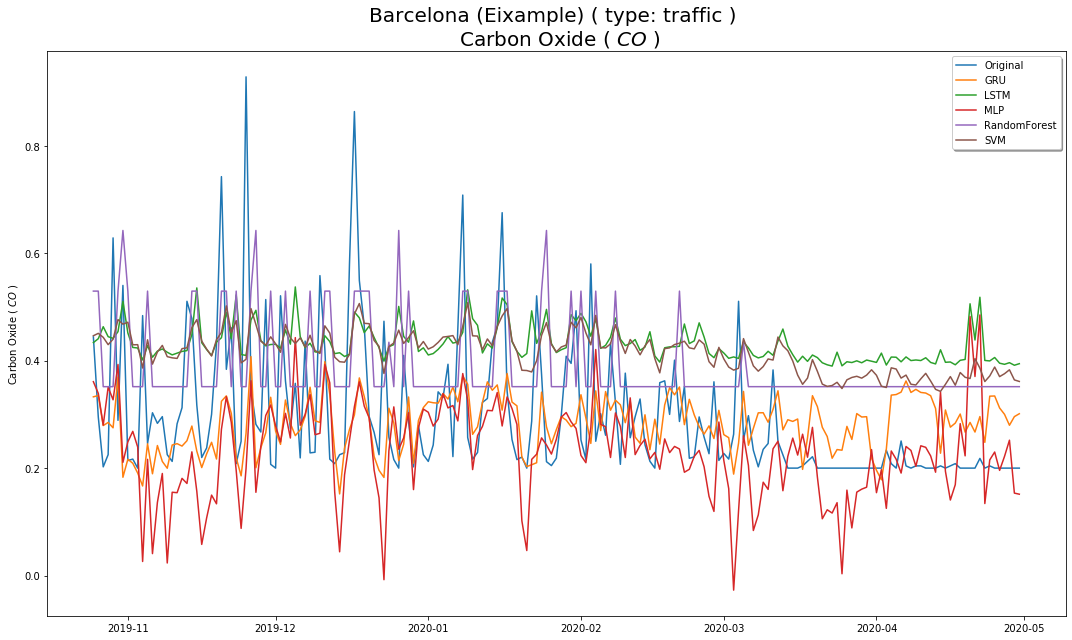

In [20]:
station, output = 8019043, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations,subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Según los resultados mostrados en la siguiente tabla, vemos que el mejor valor de $RMSE$ se obtiene con el modelo $GRU$. Sin embargo, vemos que los valores de $R^2$ son muy bajos. Lo cual nos indica que la predicción conseguida no es muy buena.

In [21]:
show_model_evaluation_stats(stats, title)

Ejecutamos ahora los modelos para la estación de **Gracia - Sant Gervasi**. Esta estación está definida como de tipo **traffic**, igual que la anterior estación.

En este caso, ya sobre la gráfica de abajo, observamos un mejor ajuste de las predicciones realizadas con cada uno de los modelos que el conseguido en la estación anterior. Para poder determinar la causa de esta diferencia deberíamos de realizar un análisis más profundo sobre la distribución de los datos en cada una de las estaciones.

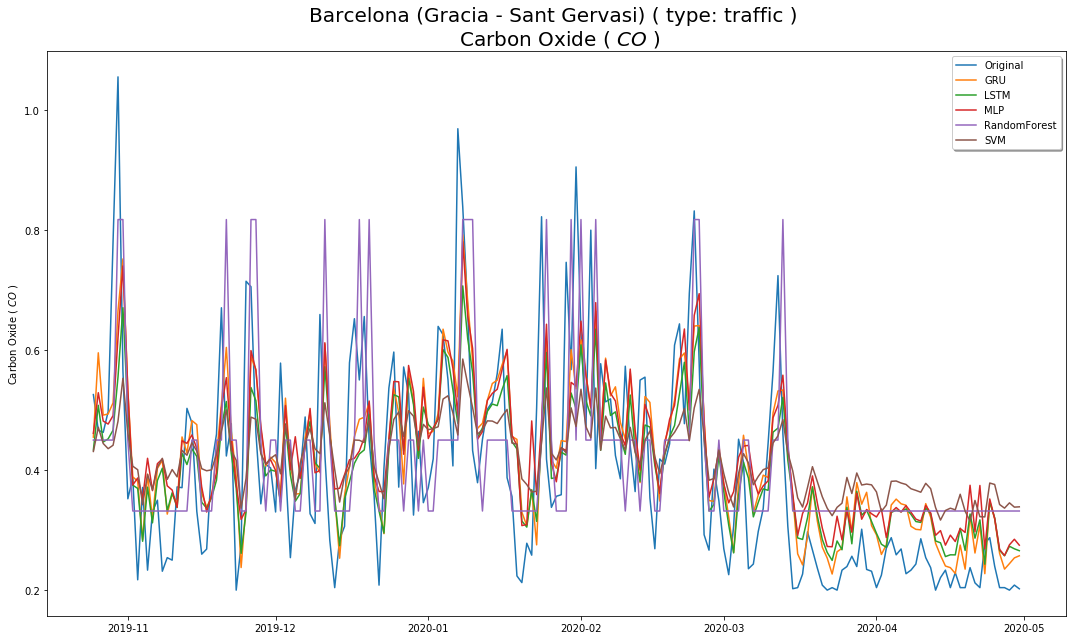

In [22]:
station, output = 8019044, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations,subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Seguidamente mostramos la tabla con los resultados para esta estación. Aqui confirmamos el mejor comportamiento de los modelos de predicción sobre los datos de esta estación. Vemos como el valor de $R^2$ alcanza valores más cercanos a uno. El mejor resultado volvemos a obtenerlo al ejecutar el modelo $GRU$ con el total de los datos.

In [23]:
show_model_evaluation_stats(stats, title)

Es el turno ahora de la estación de **Parc Vall Hebron**, la primera analizada de tipo **background**.

En la gráfica de abajo, podemos observar un mejor ajuste a los datos originales de los valores predichos para los modelos basados en redes neuronales.

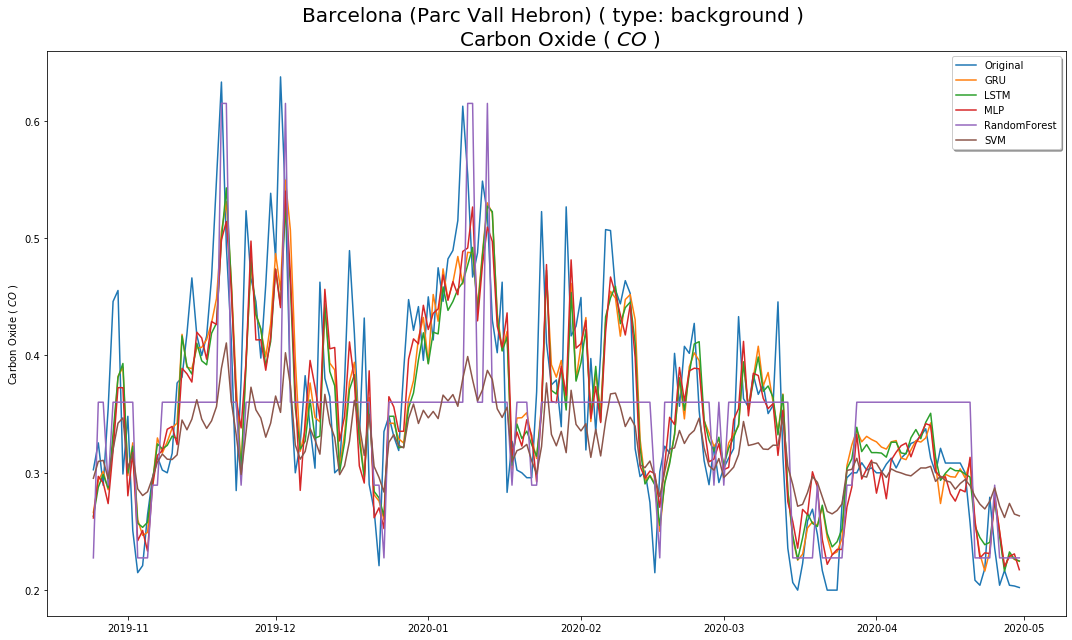

In [24]:
station, output = 8019054, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations,subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Si mostrados los resultados de la ejecución de estos modelos sobre una tabla, podremos ver que el ajuste de las predicciones realizadas es aún mayor que el alcanzado en la estación anterior $R^2=0.65$. En este caso, los tres modelos basados en redes neuronales: $MLP$, $LSTM$ y $GRU$, obtienen resultados parecidos.

In [25]:
show_model_evaluation_stats(stats, title)

Por último, ejecutamos los modelos para la otra estación de tipo **background**, la estación de **Palau Reial**.

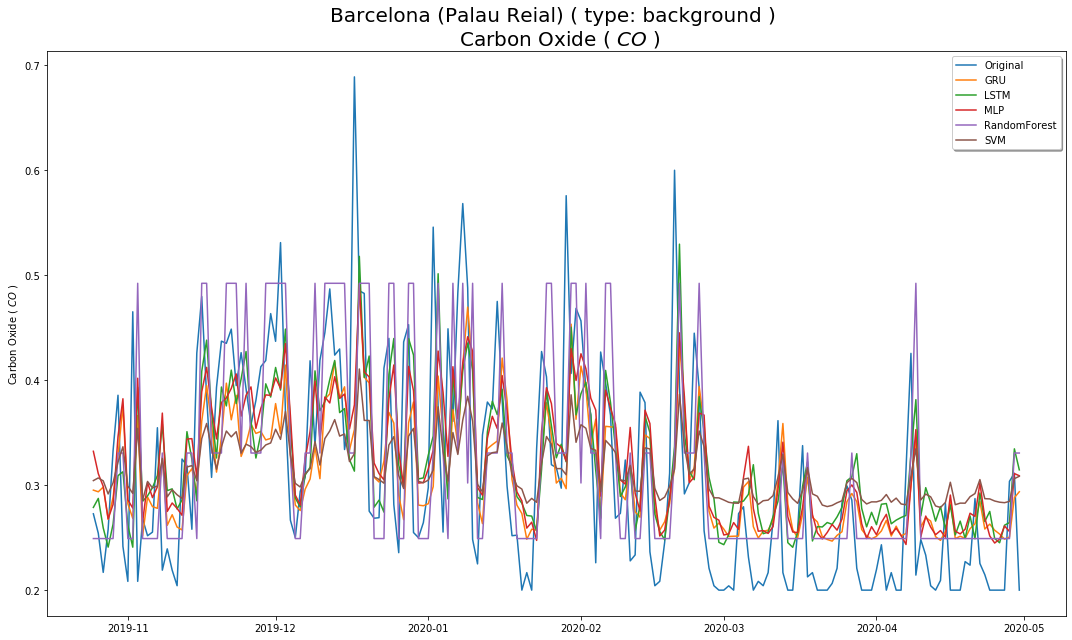

In [26]:
station, output = 8019057, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations,subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Igualmente, en la tabla de resultado mostrada abajo, volvemos a observar un mejor comportamiento de los modelos basados en redes neuronales. En este caso, el mejor resultado lo obtenemos, sin embargo, para el modelo de $MLP$.

In [27]:
show_model_evaluation_stats(stats, title)

## 4.2. Resultados para la predicción del Óxido de Nitrógeno ( $NO_x$ )

Cambiamos, ahora, el contaminante que deseamos predecir con nuestros modelos. Trataremos ahora de predecir, con nuestros modelos, el nivel de óxido de nitrógeno $NO_x$ registrado en cada una de las estaciones.

Primero ejecutamos los cinco modelos para la primera de las estaciones de tipo **trafic*, la estación del **Eixample**.

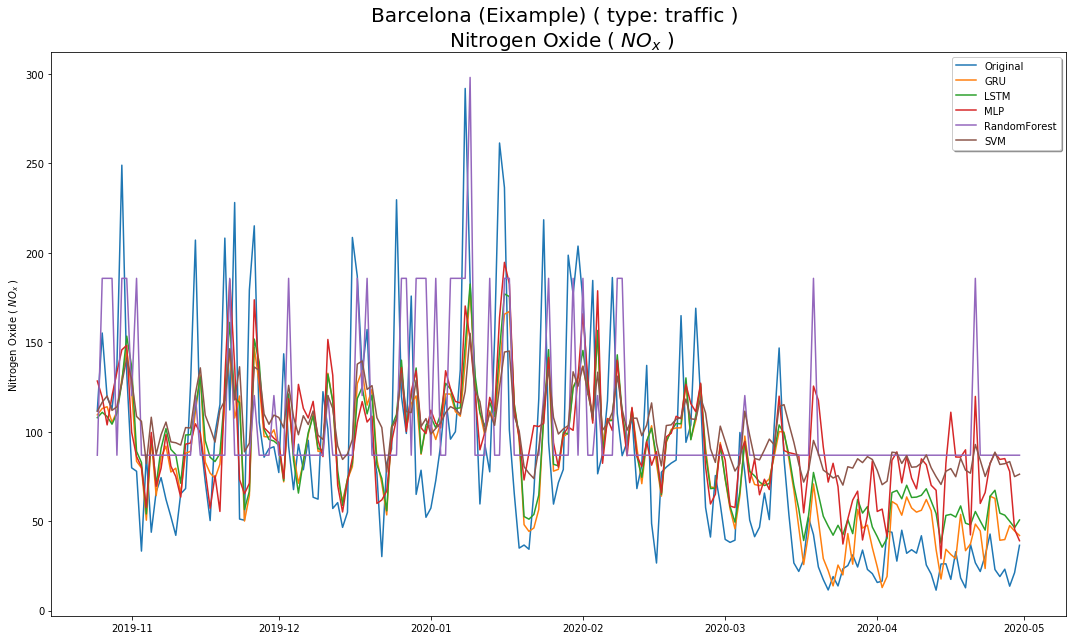

In [28]:
station, output = 8019043, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations,subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En la figura de arriba vemos como los valores predichos por cada uno de los modelos se ajusta, más o menos, a la distribución real de los valores registrados en la estación del Eixample para el óxido de nitrógeno. Si podemos observar en esta gráfica como, a partir de marzo de 2020, se produce una menor ajuste entre estos valores. Hay que tener en cuenta que durante estas fechas se produce un hecho totalmente extraordinario en todo el territorio nacional: se decreta un confinamiento estricto debido a la pandemia del COVID-19. Posiblemente, si descartaramos la predicción para estas fechas los resultados serían mejores. Aún así, se aproximan bastante a la realidad.

Abajo podemos ver la tabla con los resultados de la ejecución de cada uno de los modelos. Volvemos a ver como el método $GRU$ es el que obtiene una mejor predicción, muy cerca le sigue el método $LSTM$.

In [29]:
show_model_evaluation_stats(stats, title)

La otra estación de tipo **traffic** es **Gracia - Sant Gervasi**. La figura siguiente muestra los valores predichos con cada uno de los modelos.

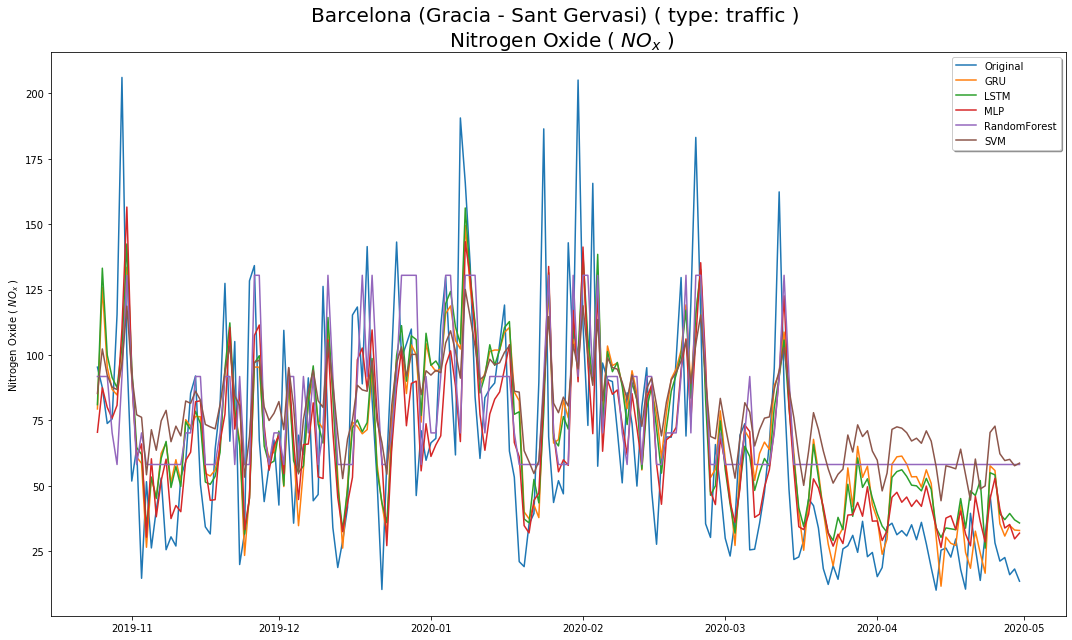

In [30]:
station, output = 8019044, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations,subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Como antes, mostramos una tabla con los resultados. El modelo $GRU$ vuelve a ser el que presenta mejores resultados, aunque sin casi diferencia con los modelos $LSTM$ y $MLP$.

In [31]:
show_model_evaluation_stats(stats, title)

Los resultados para la estación de **Parc Vall Hebron**, de tipo **background**, podemos verlos en la figura y tabla siguientes.

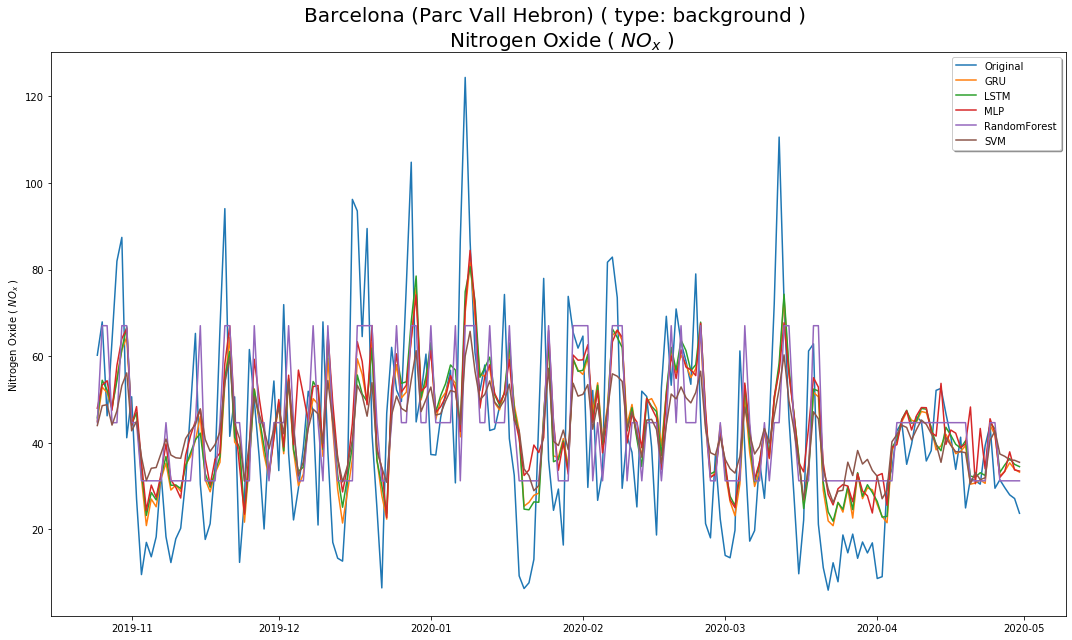

In [32]:
station, output = 8019054, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, no parece apreciar tanto el efecto COVID-19 sobre la gráfica. 

En la tabla de abajo, podemos ver la relativa igualdad entre los tres modelos basados en redes neuronales. El mejor resultado es para el modelo $GRU$.

In [33]:
show_model_evaluation_stats(stats, title)

La última estación analizada es de **Palau Reial**.

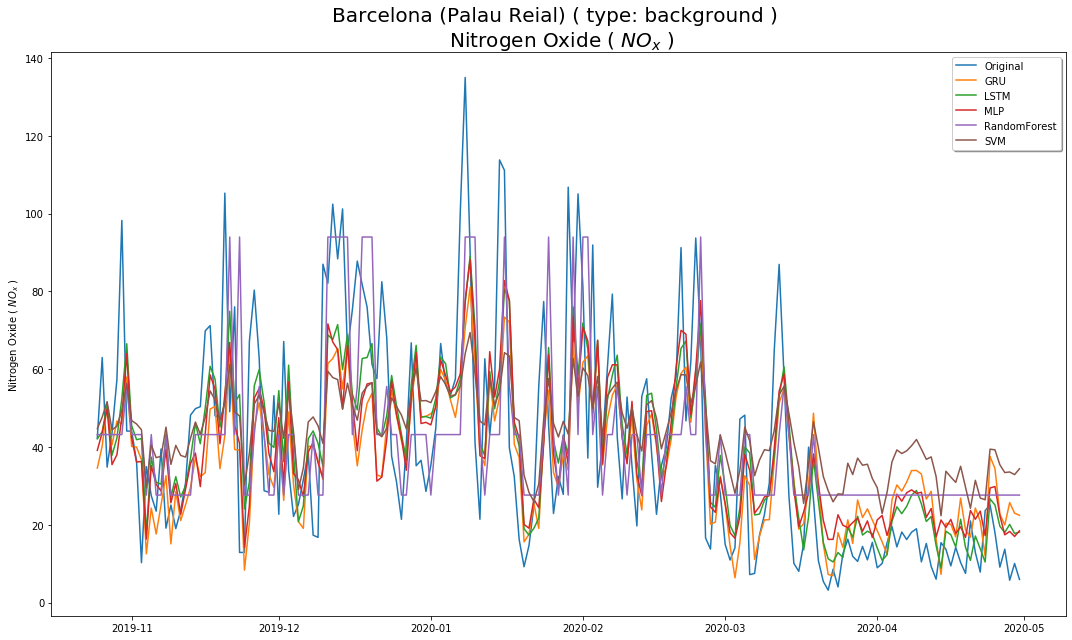

In [34]:
station, output = 8019057, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, vemos en la tabla como, el método $GRU$ baja un poco su rendimiento. El cual es superado por los otros dos modelos de $LSTM$ y $MLP$.

In [35]:
show_model_evaluation_stats(stats, title)

## 4.3. Resultados para la predicción del Dióxido de Nitrógeno ( $NO_2$ )

Otro contaminante que vamos a tratar de predecir es el dióxido de nitrógeno $NO_2$. Como ya hemos visto este contaminante está muy relacionado con el óxido de nitrógeno.

Como siempre, empezamos con la estación del **Eixample**.

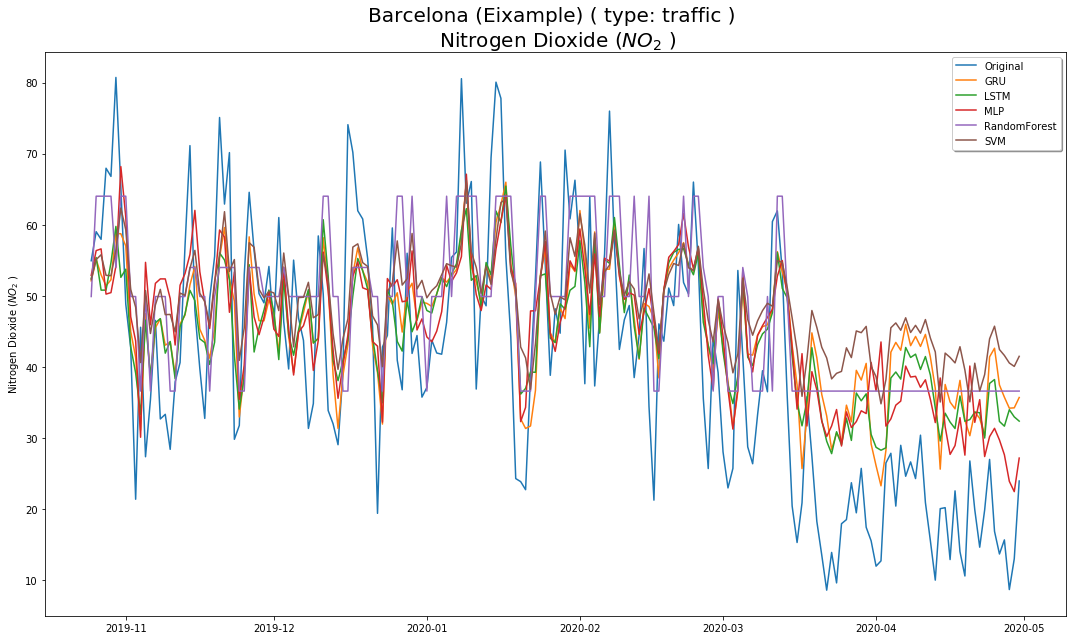

In [36]:
station, output = 8019043, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, la mejor valoración sería para el modelo de $LSTM$, sin embargo, el valor de $RMSE$ es idéntico en los tres modelos: $MLP$, $LSTM$ y $GRU$.

In [37]:
show_model_evaluation_stats(stats, title)

A continuación, ejecutamos los modelos para la estación de **Gracia - Sant Gervasi**.

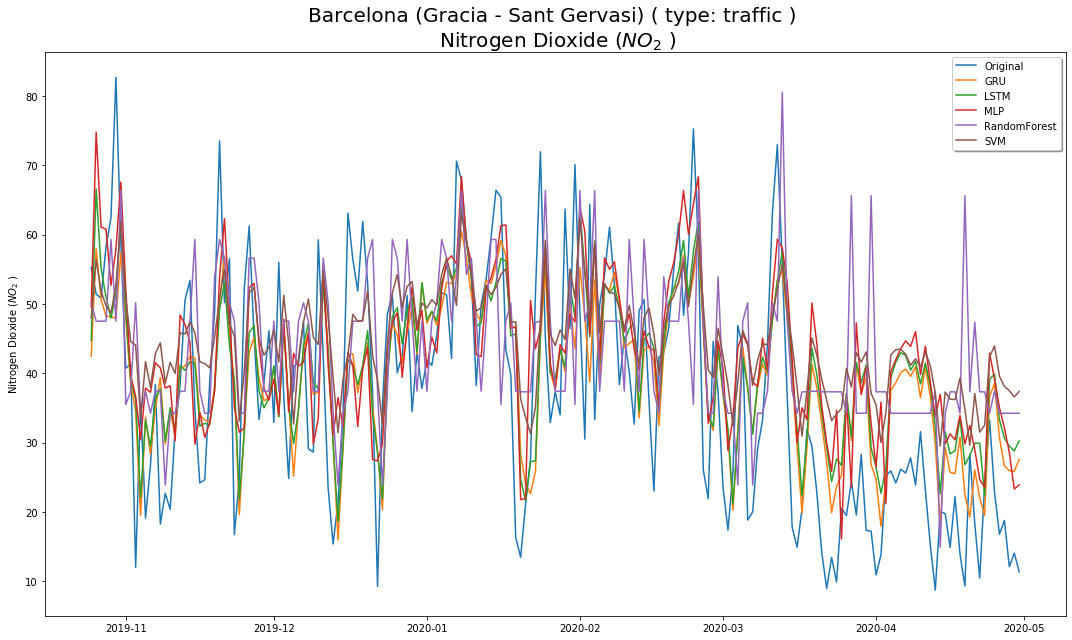

In [38]:
station, output = 8019044, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Vemos, como en la mayoría de los casos, el efecto COVID-19. Observando una mayor diferencia entre los valores predichos y los reales. 

En cuanto a la clasificación de los modelos, vemos clara mejoría con el modelo de $GRU$.

In [39]:
show_model_evaluation_stats(stats, title)

Seguidamente, presentamos los resultados para la estación de **Parc Vall Hebron**.

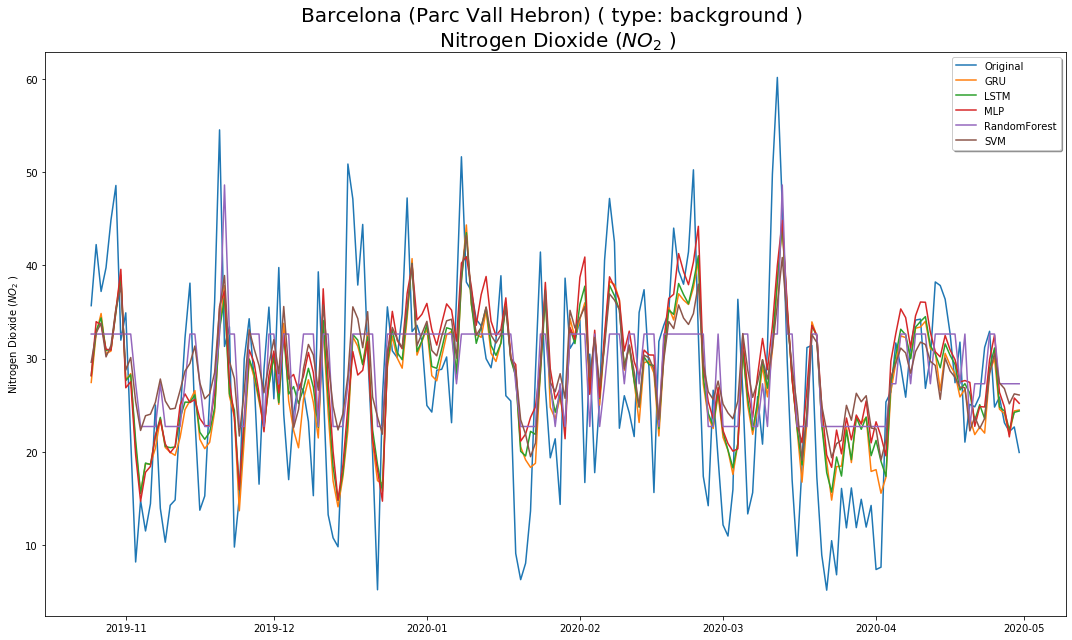

In [40]:
station, output = 8019054, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Como antes, el efecto COVID-19 se deja apreciar menos. 

La clasificación de los distintos modelos, según la siguiente tabla, es liderada por el modelo $GRU$. Sin embargo, el valor de $RMSE$ es igual, o muy similar, en todos los casos.

In [41]:
show_model_evaluation_stats(stats, title)

Para finalizar este subapartado, incluimos los resultados para la estación de **Palau Reial**.

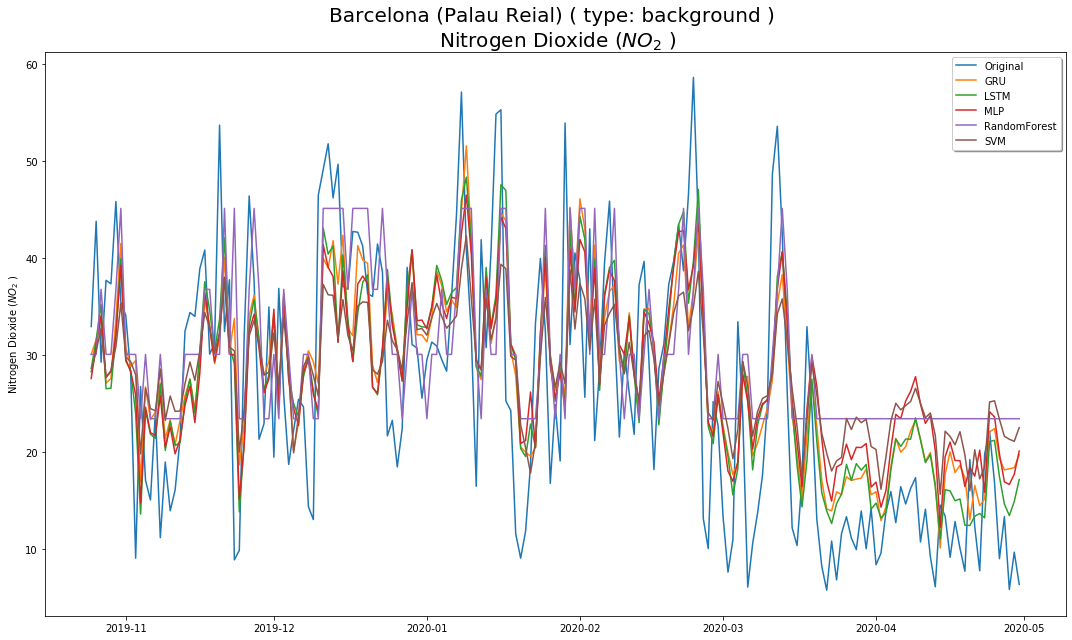

In [42]:
station, output = 8019057, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En esta gráfica resulta muy notable el efecto denominado COVID-19. 

La siguiente tabla indica que el mejor modelo, en este caso, es el de $LSTM$. Muy igualado a los de $GRU$ y $MLP$.

In [43]:
show_model_evaluation_stats(stats, title)

## 4.4. Resultados para la predicción del Ozono ( $O_3$ )

Concluimos estos subapartados con la presentación y análisis de los resultados de la ejecución de los modelos, tomando como variables a predecir el nivel de ozono en el aire (en la troposfera). 

Empezamos con los resultados para la estación del **Eixample**.

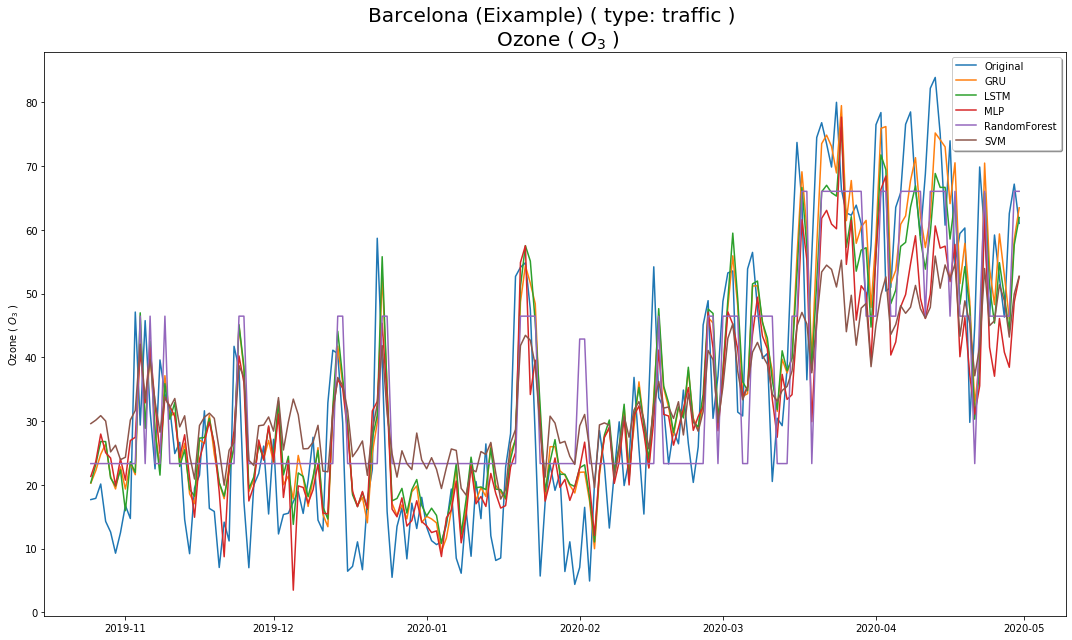

In [44]:
station, output = 8019043, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Vemos que el ajuste es bastante bueno, incluso en los meses de confinamiento por la pandemia del COVID-19.

En la siguiente tabla, vemos como es el modelo $GRU$ el que obtiene mejores resultados.

In [45]:
show_model_evaluation_stats(stats, title)

Para la estación de **Gracia - Sant Gervasi** tenemos la siguiente gráfica. En ella, quizá, apreciamos un peor ajuste hacia el final de la gráfica (coincidiendo en el periodo extraordinario atribuible al COVID-19). Sin embargo, el ajuste resulta bastante bueno, como después confirmaremos con los datos de la siguiente tabla.

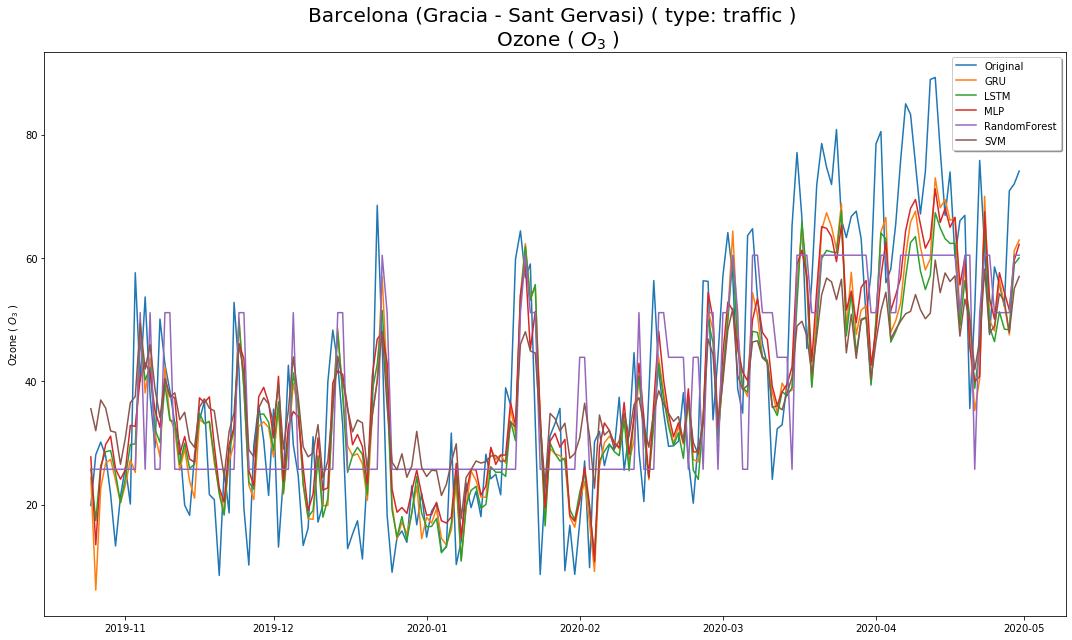

In [46]:
station, output = 8019044, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En la siguiente tabla, volvemos a ver como el método $GRU$ obtiene el mejor valor de $RMSE$, aunque, en este caso, resulta con un mejor valor de $R^2$ el método de $MLP$.

In [47]:
show_model_evaluation_stats(stats, title)

A continuación, se presentan los resultados para la estación de **Parc Vall Hebron**.

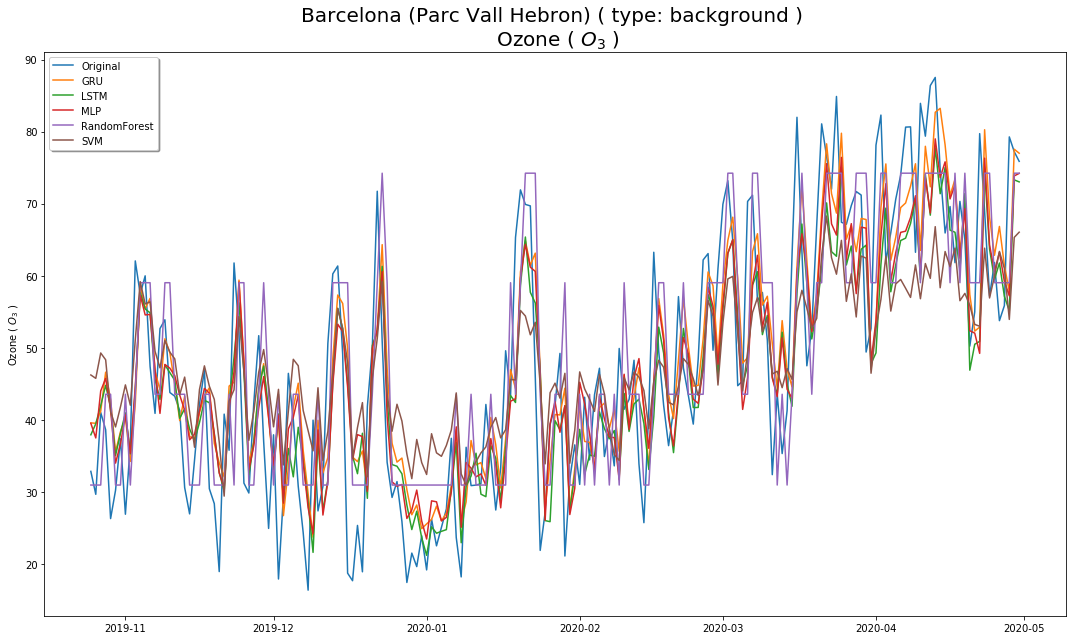

In [48]:
station, output = 8019054, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Volvemos a ver, en la tabla de abajo, como la mejor puntuación la obtenemos para el modelo $MLP$, aunque la diferencia con $GRU$ y $LSTM$ es mínima.

In [49]:
show_model_evaluation_stats(stats, title)

Terminamos con los resultados para la estación de **Palau Reial**. En la gráfica de abajo apreciamos un peor comportamiento del modelo $SVM$ para los meses de confinamiento por COVID-19. El resto de modelos parece comportarse adecuadamente en todo los casos.

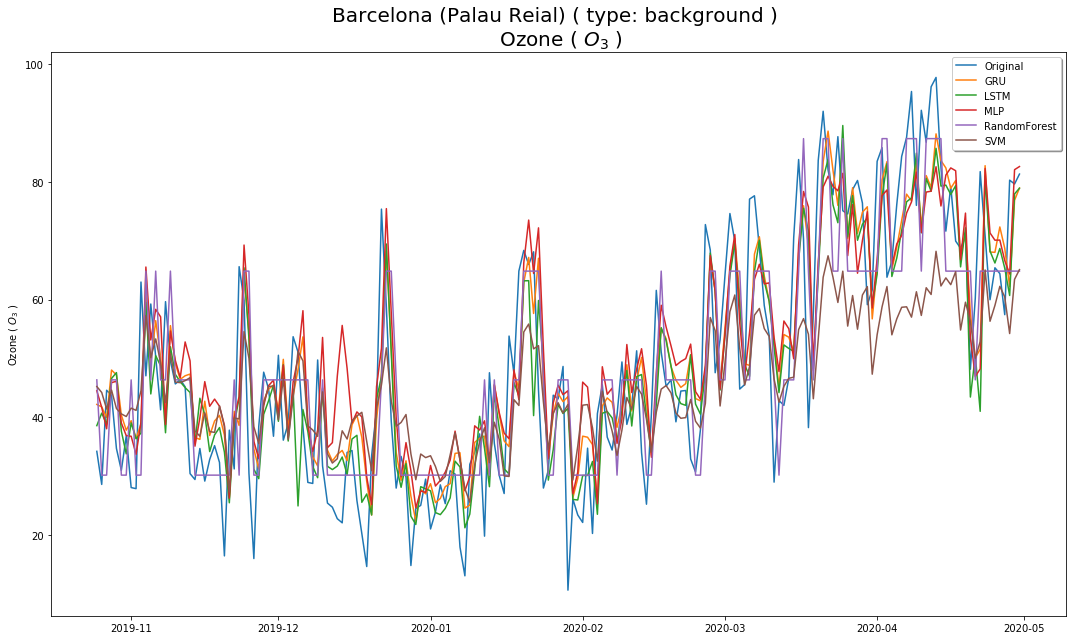

In [50]:
station, output = 8019057, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_models(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En la tabla siguiente, volvemos a ver como mejor modelo el $GRU$, practicamente igualado al $LSTM$.

In [51]:
show_model_evaluation_stats(stats, title)

# 5. Evaluación de datos de entrada

Como análisis adicional a este estudio, incluimos aqui una evaluación de la influencia de las distintas topologías de datos disponibles, sobre los resultados de predicción de cada uno de los contaminantes considerados, en cada una de las estaciones de observación de la calidad del aire de la ciudad de Barcelona.

Para realizar este análisis lo primero que haremos es crear una nueva función a partir de la función anterior que utilizamos para guiar el anterior análisis. En este caso, utilizaremos unicamente el modelo $GRU$, pues es el que hemos visto procura mejores resultados en la mayoría de los casos y, puesto que de lo que se trata es de comparar los datos de entrada, no creemos necesario evaluar con distintos modelos. 

Para analizar la influencia de las distintas topologías de datos ejecutamos los modelos de predicción para los distintos contaminantes, en cada una de las estaciones estudiadas, utilizando como variables independientes los siguientes grupos de datos:

- grupo '**_air_meteo_trafic_**', el cual contendrá todo el conjunto de datos, lo cual incluye datos de contaminación del aire, datos meteorológicos y datos de tránsito de vehículos.
- grupo '**_air_meteo_**', formado por los datos de contaminación del aire y datos meteorológicos.
- grupo '**_air_trafic_**', formado por los datos de contaminación del aire y datos de tránsito de vehículos. 
- grupo '**_air_**', únicamente contendrá los datos de contaminación del aire.

Este análisis complementa el análisis de variables más relevantes realizado en notebooks anteriores.

In [52]:
from math import sqrt
from statistics import mean
from time import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

# Dictionary with model functions
model_func_dict = {
    'RandomForest':RandomForest_Model,
    'SVM':SVM_Model,
    'MLP': MLP_Model,
    'LSTM':LSTM_Model,
    'GRU':GRU_Model,
}
    
def evaluate_inputs(data_air, data_meteo, data_trafic, station, output, tuning_data, 
                    title=None, ylabel=None, show_plot=True, show_train=False, 
                    model_func_dict=model_func_dict):
    '''
    Evaluate the different models using tuned hyperparameters for the given station and output.
    
    Inputs:
    
        - data_air: dataframe of air timeseries.
        - data_meteo: dataframe of meteo timeseries.
        - data_trafic: dataframe of trafic timeseries.
        - station: air station code.
        - output: column' name predicted.
        - tuning_data: parameterization data.
        - title: figure title.
        - ylabel: y axis label.
        - show_plot: whether plot is shown.
        - show_train: whether train data must be displayed in the plot.
        - model_func_dict: dictionary to assign a model function to every model's name.
        
    return figure with plotted data and models execution statistics for all the evaluated models.
    '''
    
    n_steps_in = 1
    n_steps_out = 1
    train_test_split = 0.8
        
    # Get merged hourly data for given station
    data_hourly = get_station_data(station, data_air, data_meteo, data_trafic)
    data_hourly = data_hourly.set_index('DATA').interpolate(method='time', limit_area='inside')         
    data_hourly.dropna(inplace=True)

    # Resample data daily
    data_daily = data_hourly.resample('D').mean() 
    indexes = data_daily.index[n_steps_in:]
    
    # Get best tuned model hyperparameters for the given station and output 
    tuning = tuning_data \
                .loc[(tuning_data['CODI_EOI'] == station) & \
                     (tuning_data['y_columns'] == "['{}']".format(output))] \
                 .groupby(['Model'], sort=True) \
                 .apply(lambda x: x.sort_values(['RMSE']) \
                     [['Model','vars_selection_method',
                       'x_columns','y_columns','params',
                       'R2','RMSE']] \
                 .head(1)) \
                 .reset_index(drop=True)    
    
    
    x_columns_inputs = {
            'air_meteo_trafic':['CO', 'NO', 'NO2', 'NOX', 'O3', 'SO2', 'DV10', 'HR', 'P', 'PPT', 'RS', 'T', 'VV10', 'traffic'],
            'air_meteo':['CO', 'NO', 'NO2', 'NOX', 'O3', 'SO2', 'DV10', 'HR', 'P', 'PPT', 'RS', 'T', 'VV10'],
            'air_trafic':['CO', 'NO', 'NO2', 'NOX', 'O3', 'SO2', 'traffic'],
            'air':['CO', 'NO', 'NO2', 'NOX', 'O3', 'SO2'],
        }
    
    # Dataframe to save models execution stats
    stats = pd.DataFrame()
    
    # Loop for every tuned model
    first = True
    plt.figure(figsize=(15, 10))
    for index,row in tuning.iterrows():
        #print('{} {} {}'.format(row['Model'],row['params'],row['x_columns']))
        
        # Get tuned data for a model
        model_name = row['Model']
        model_func = model_func_dict[model_name]
        params = eval(row['params'])
        x_columns = eval(row['x_columns'])
        y_columns = eval(row['y_columns']) 
        
        if model_name not in ['GRU']: continue
            
        for x_columns_input in x_columns_inputs:
            x_columns = x_columns_inputs[x_columns_input]

            # Prepare data for prediction model
            reframed = prepare_data(data_daily, x_columns, y_columns, n_steps_in, n_steps_out)

            # Define scaler as MinMaxScaler between 0 to 1
            scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

            # Scale data
            values = reframed.values.astype('float32')
            scaled = scaler.fit_transform(values)

            # Get number of input and output features
            nro_x_columns = len(x_columns)
            nro_y_columns = len(y_columns)
            n_in_features = nro_x_columns*n_steps_in
            n_out_features = nro_y_columns*n_steps_out

            # Get X and y samples
            X = scaled[:,:-n_out_features]
            y = scaled[:,-n_out_features]

            # split into train and test sets
            X_train = X[:int(X.shape[0]*train_test_split)]
            X_test = X[int(X.shape[0]*train_test_split):]
            y_train = y[:int(X.shape[0]*train_test_split)]
            y_test = y[int(X.shape[0]*train_test_split):]

            # Define model
            model = model_func(nro_x_columns, nro_y_columns, n_steps_in, n_steps_out, params)

            # Run model w.r.t. tuned hyperparameters
            start_time = time()
            model = model_fit(model, model_name, params, X_train, y_train, n_steps_in)
            duration = time() - start_time

            # Predict values for test data
            yhat = model_predict(model, model_name, X_test, n_steps_in, n_out_features)        

            # Evaluate model results
            r2 = r2_score(y_test, yhat) 
            rmse = sqrt(mean_squared_error(y_test, yhat))

            # Record model execution stats
            row_stats = {}                 
            row_stats['Model'] = [model_name]
            row_stats['params'] = [params]
            row_stats['vars_method'] = [x_columns_input]
            row_stats['x_columns'] = [x_columns]
            row_stats['y_columns'] = [y_columns]
            row_stats['Samples_train'] = [y_train.shape[0]] 
            row_stats['Samples_test'] = [y_test.shape[0]]
            row_stats['Duration'] = [duration]
            row_stats['R2'] = [r2]
            row_stats['RMSE'] = [rmse]
            stats = stats.append(pd.DataFrame.from_dict(row_stats), ignore_index=True, sort=False)

            # Reshape y data for apply inverse transformation
            y_train = y_train.reshape((len(y_train), n_out_features))
            y_test = y_test.reshape((len(y_test), n_out_features))

            # Reverse scaler transformation
            y_train_inv = invert_scaled(X_train, y_train, scaler, n_out_features)
            y_test_inv = invert_scaled(X_test, y_test, scaler, n_out_features)
            yhat_inv = invert_scaled(X_test, yhat, scaler, n_out_features)

            # Plot model execution data
            if show_plot:
                if first:
                    if show_train:
                        plt.plot(pd.Series(np.concatenate((y_train_inv, y_test_inv)), index=indexes), label='Original')
                    else:
                        plt.plot(pd.Series(y_test_inv, index=indexes[int(indexes.shape[0]*train_test_split):]), label='Original')
                    first = False

                plt.plot(pd.Series(yhat_inv, index=indexes[int(indexes.shape[0]*train_test_split):]), label=x_columns_input)

    if show_plot:
        plt.legend(loc='best', shadow=True)
        if title: plt.title(title, fontsize=20)
        if ylabel: plt.ylabel(ylabel)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()
    
    return stats

Seguidamente, en los siguientes subapartados, ejecutamos el modelo para cada uno de los contaminantes y estación de observación de calidad del aire. Mostramos los resultados obtenidos en cada caso y realizamos un breve análisis de los mismos.

## 5.1. Resultados para la predicción del Óxido de Carbono ( $CO$ )

Como anteriormente, empezamos nuestro análisis utilizando nuestros modelos para predecir el nivel de óxido de carbono $CO$ en cada una de las estaciones. Empezamos por la estación del **Eixample**.

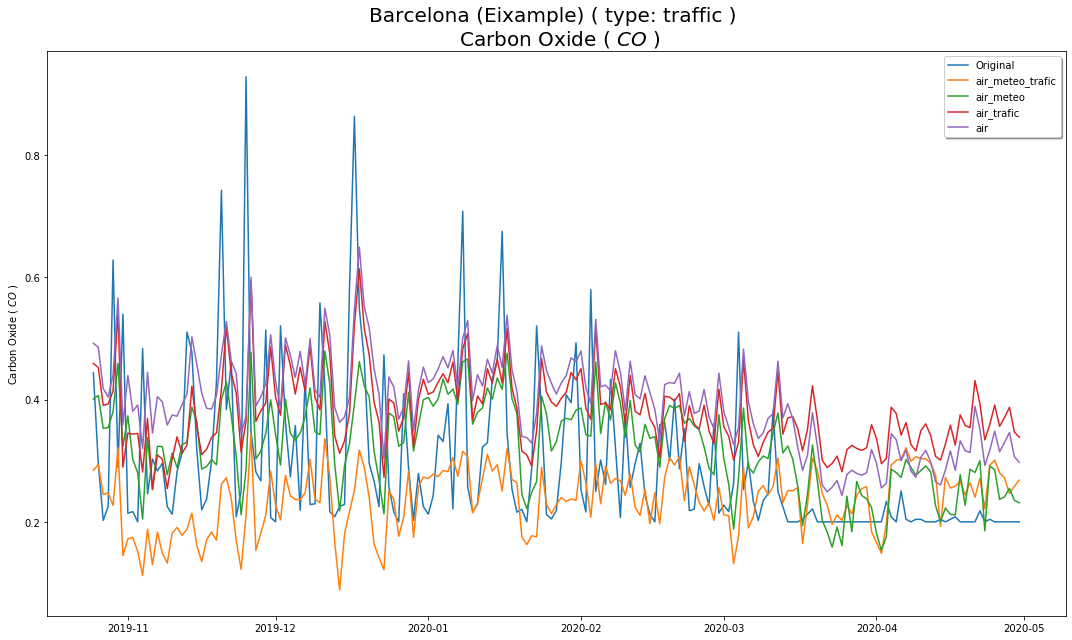

In [53]:
station, output = 8019043, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Según vemos en la gráfica de arriba, y confirmamos en la siguiente tabla, los conjuntos de datos que mejores resultados dan son aquellos que incluyen datos meteorológicos. En el caso de la gráfica para **_air_meteo_trafic_**, vemos que se comporta mejor en los primeros meses de predicción, hasta, más o menos, marzo de 2020, fecha en la cual se empieza a imponer en todo el territorio nacional restricciones de desplazamiento. Lo cual puede explicar la menor influencia del tráfico en los resultados.

In [54]:
show_model_evaluation_stats(stats, title)

Toca evaluar los resultados para la estación de **Gracia - Sant Gervasi**.

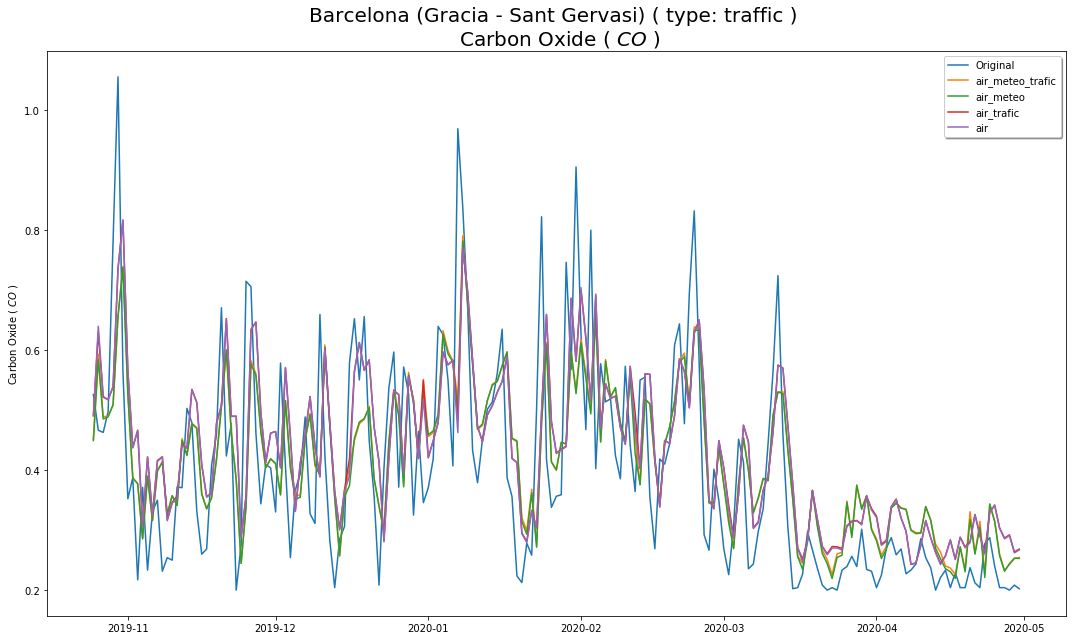

In [55]:
station, output = 8019044, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso observamos un mejor ajuste de las distintas predicciones a los datos reales. Volvemos a observar como aquellos modelos ejecutados incluyendo datos meteorológicos ofrecen mejores resultados, notando cierta mejoría al incluir los datos de tráfico.

In [56]:
show_model_evaluation_stats(stats, title)

Cabe decir que las dos estaciones anterior están clasificadas como de tipo **traffic**. Lo cual, en principio, indica su mayor influencia por gran volumen de tráfico.

Pasamos ahora a analizar los resultados sobre las dos estaciones de tipo **background**. Empezamos por la estación de **Parc Vall Hebron**.

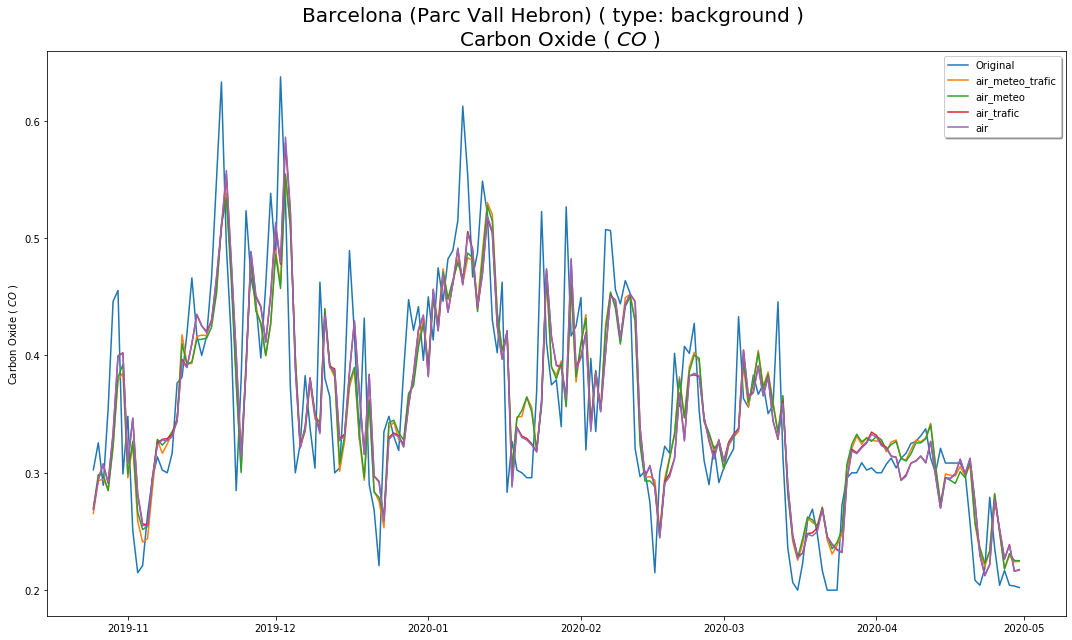

In [57]:
station, output = 8019054, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso el ajuste conseguido, en todos los supuestos, es aún mayor. Seguimos apreciando cierta mejoría al incluir datos meteorológicos en los predictores. Sin embargo, no apreciamos influencia en esta estación de los datos de tráfico.

In [58]:
show_model_evaluation_stats(stats, title)

La otra estación de tipo **background**, es **Palau Reial**. En este caso, a pesar de la clasificación de la estación como *background*, tal y como vimos en el análisis inicial de los datos, se observa una gran influencia de los datos de tránsito de vehículos. Lo cual se puede apreciar en la siguiente gráfica: 

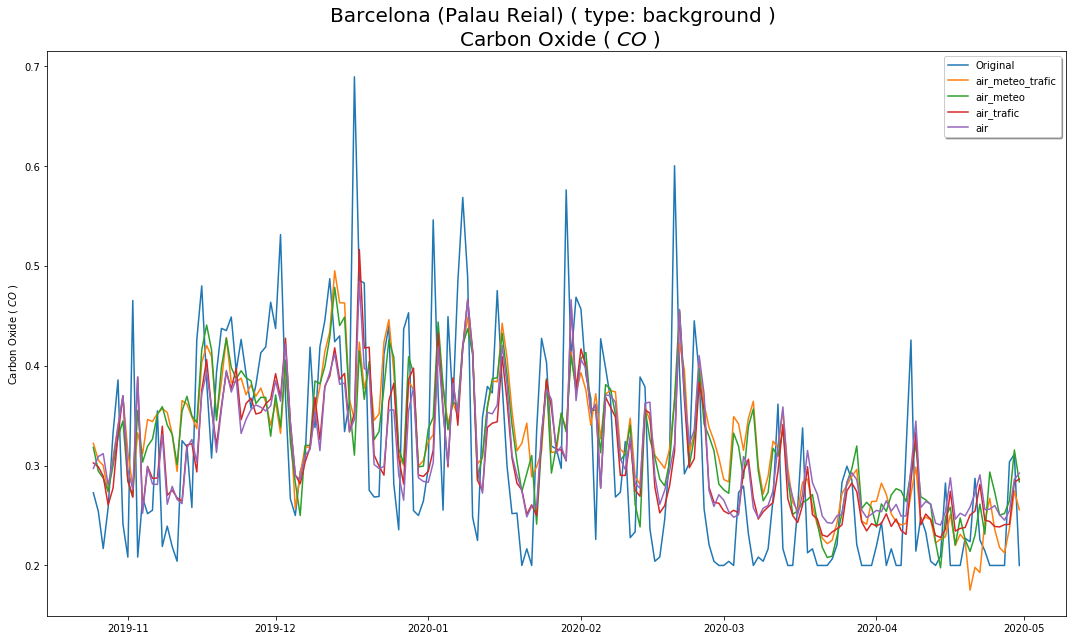

In [59]:
station, output = 8019057, "CO"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En la tabla de abajo, confirmamos la mayor influencia de los datos de tráfico sobre las predicciones de esta estación. En este caso, el mejor resultado lo obtenemos con el grupo de datos **_air_trafic_**, lo cual nos lleva a pensar que los datos meteorológicos influyen muy poco en la contaminación de esta estación.

In [60]:
show_model_evaluation_stats(stats, title)

## 5.2. Resultados para la predicción del Óxido de Nitrógeno ( $NO_x$ )

Realizaremos ahora el mismo estudio utilizando la variable de óxido de nitrógeno $NO_x$ como variable dependiente.

La primera estación analizada es la del **Eixample**, de tipo **traffic**.

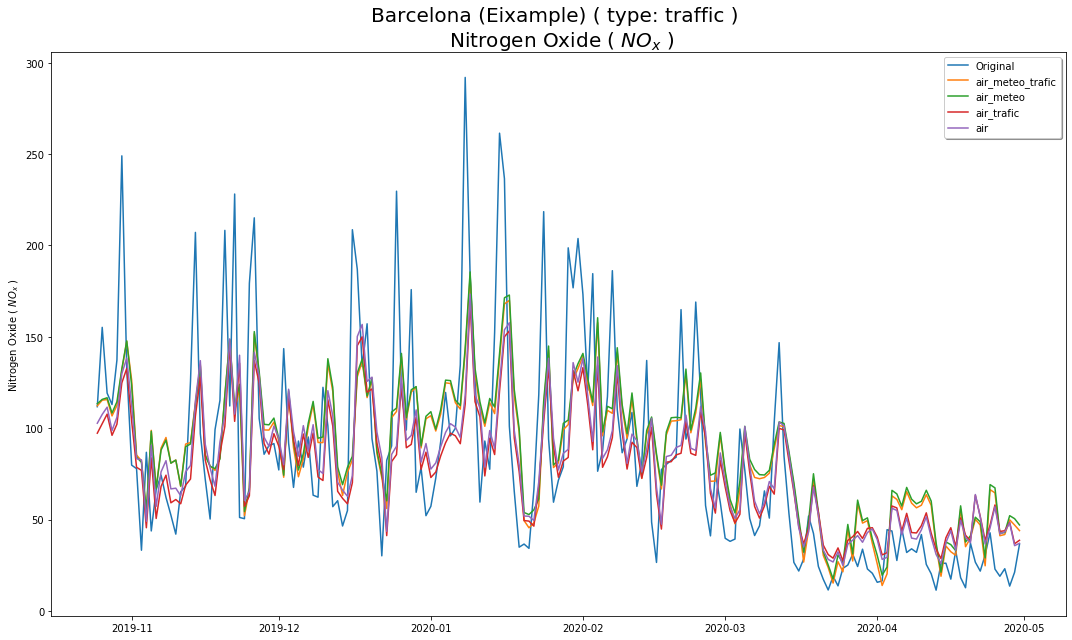

In [61]:
station, output = 8019043, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, los datos de tráfico parecen penalizar, o no aportar a, los resultados de la predicción. Vemos que los mejores resultados los obtenemos al incluir el factor meteorológicos a los predictores. No notamos mejoría al añadir los datos de tráfico, e incluso vemos cierta penalización en el caso de tomar solamente en cuenta estos junto a los datos de contaminación del aire.

In [62]:
show_model_evaluation_stats(stats, title)

Para la otra estación de tipo **traffic**, **Gracia - Sant Gervasi**, obtenemos las siguientes predicciones para los distintos grupos de variables predictoras.

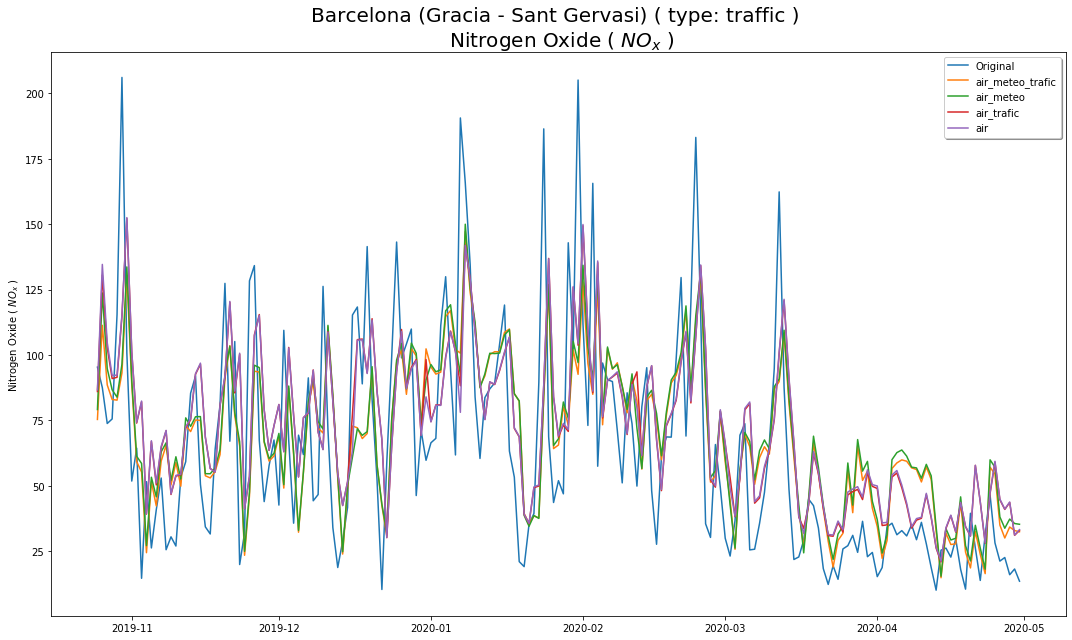

In [63]:
station, output = 8019044, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, vemos como la inclusión de datos de tráfico en el conjunto de variables independientes ha influido positivamente en la predicción final. El mejor resultado se obtiene con el grupo de datos que contiene todas las variables: **_air_meteo_trafic_**.

In [64]:
show_model_evaluation_stats(stats, title)

Ahora vamos con las estaciones de tipo **background**, en las que cabe esperar una menor influencia del tráfico. Así, para la estación de **Parc Vall Hebron** tenemos:

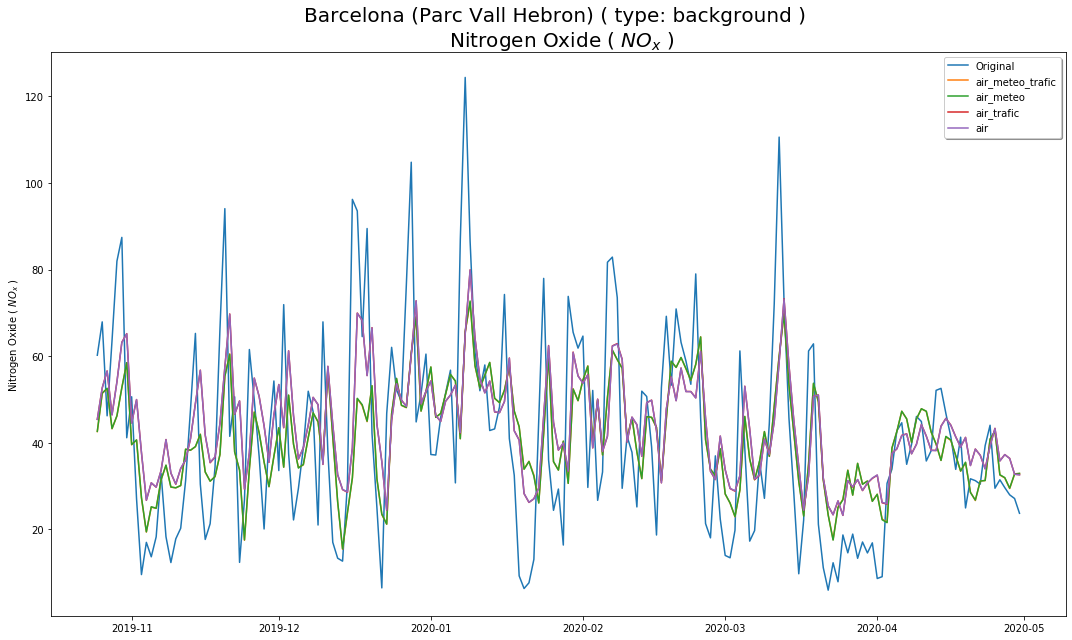

In [65]:
station, output = 8019054, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Volvemos a constatar, de acuerdo a los datos mostrados en la tabla siguiente, la poca influencia, o nula, de los de tráfico en la predicción del óxido de nitrógeno en esta estación.

In [66]:
show_model_evaluation_stats(stats, title)

Terminamos este bloque con la estación de **Palau Reial**. En este caso, sí existe influencia de los datos relativos al tráfico en la predicción final, como podemos ver en la gráfica y tabla siguientes.

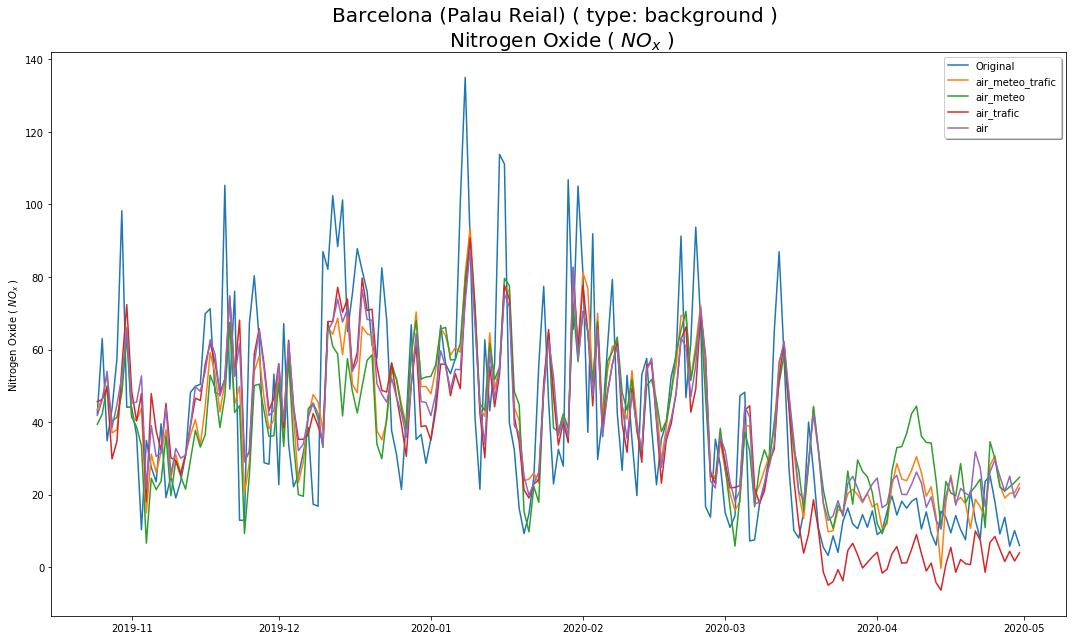

In [67]:
station, output = 8019057, "NOX"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Como vemos en la tabla, los mejores resultados los obtenemos para el grupo de variables independientes que unicamente tiene en cuenta los datos de contaminación del aire y el tráfico.

In [68]:
show_model_evaluation_stats(stats, title)

## 5.3. Resultados para la predicción del Dióxido de Nitrógeno ( $NO_2$ )

Vayamnos ahora con la predicción del dióxido de nitrógeno $NO_2$.

La siguiente figura muestra las predicciones obtenidas para el $NO_2$ en la estación del **Eixample**.

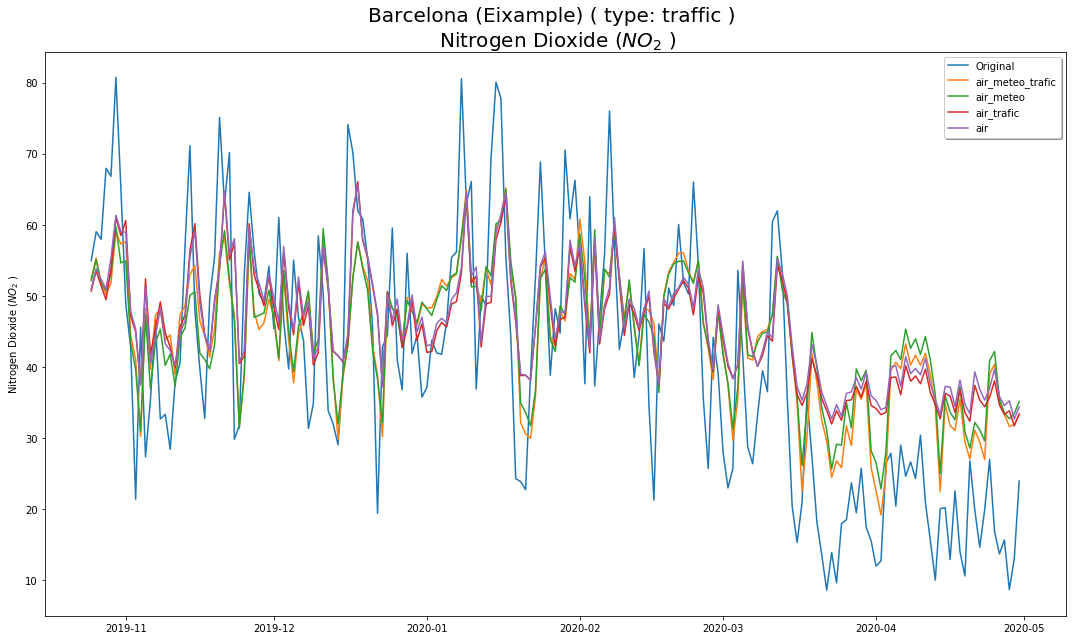

In [69]:
station, output = 8019043, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Vemos que el mejor resultado, en este caso, lo obtenemos cuando tenemos en cuenta todas las variables disponibles. Apreciamos bastante influencia de los datos de tráfico sobre la predicción, así el mejor resultado se da cuando añadimos estos datos.

In [70]:
show_model_evaluation_stats(stats, title)

Para la estación de **Gracia - Sant Gervasi**, tenemos:

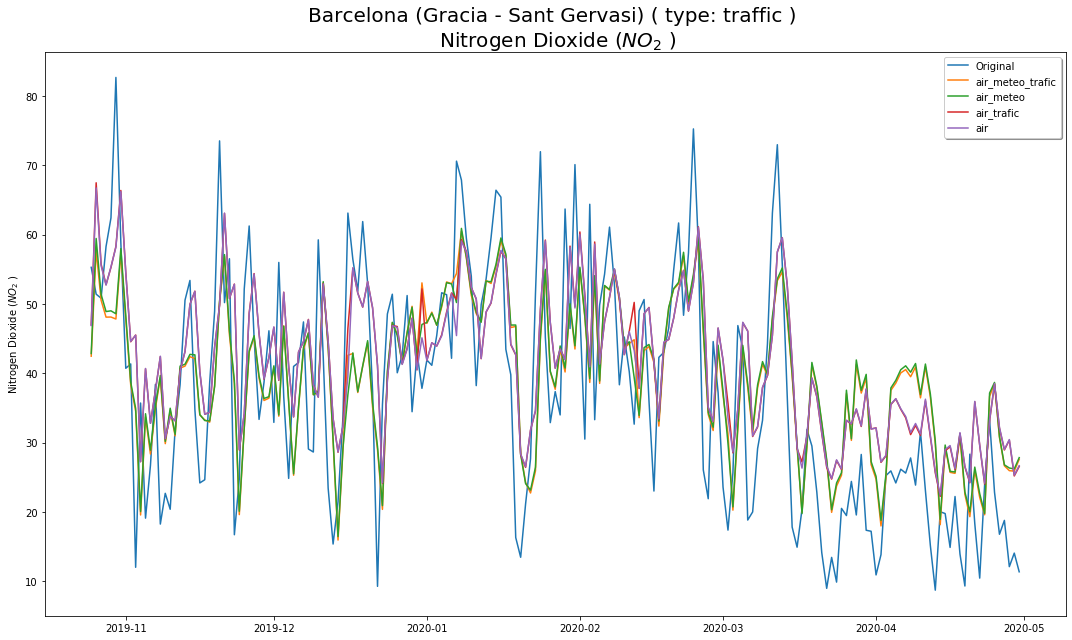

In [71]:
station, output = 8019044, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, no está muy clara la influencia de los datos de tráfico sobre las predicciones, aunque sí es cuando tenemos en cuenta todas las variables cuando tenemos el mejor resultado.

In [72]:
show_model_evaluation_stats(stats, title)

Para la estación de **Parc Vall Hebron**, obtenemos la siguiente gráfica:

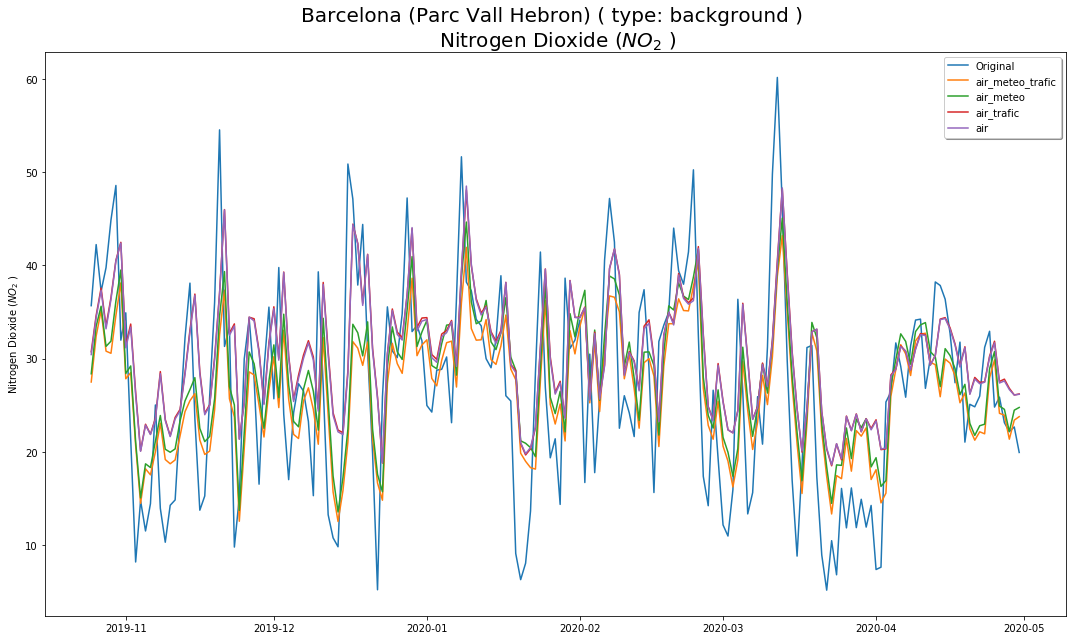

In [73]:
station, output = 8019054, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, no parece recomendable incluir los datos de tráfico en el grupo de predictores. Pues se aprecia mucha diferencia entre incluirlos o no.

In [74]:
show_model_evaluation_stats(stats, title)

Por último, mostramos las predicciones obtenidas para la estación de **Palau Reial**.

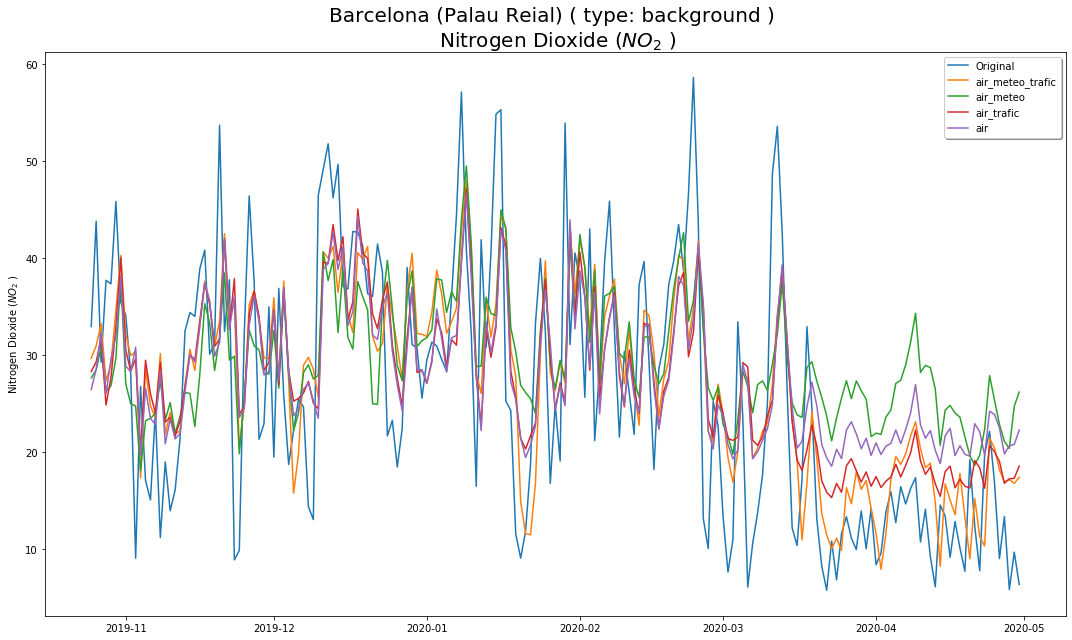

In [75]:
station, output = 8019057, "NO2"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

En este caso, a pesar de ser una estación de tipo *background*, como ya hemos visto con otros contaminantes, se aprecia una mejoría sustancial en las predicciones al incluir los datos de tráfico.

In [76]:
show_model_evaluation_stats(stats, title)

## 5.4. Resultados para la predicción del Ozono ( $O_3$ )

Concluimos este análisis mostrando los resultados de predecir el nivel de ozono $O_3$ en la troposfera utilizando los distintos grupos de datos.

Como siempre, empezamos con la estación del **Eixample**.

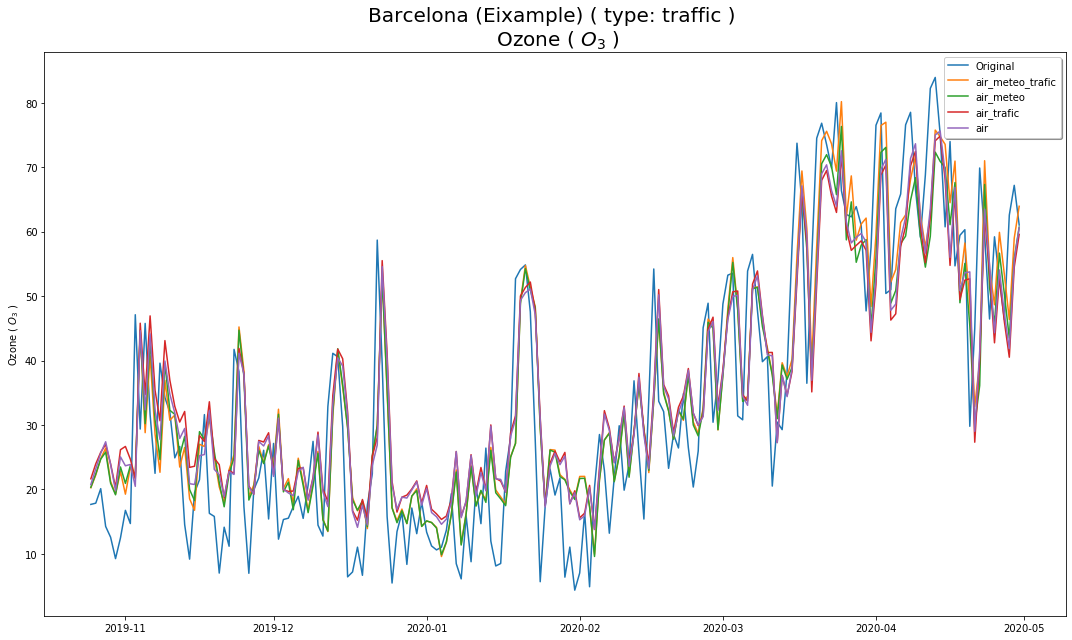

In [77]:
station, output = 8019043, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Observamos cierta mejoría según vamos incluyendo nuevos datos. Sin embargo, no está muy clara la influencia de los datos de tráfico, puesto que al ser incluido solamente con los datos de contaminación del aire el resultado de la predicción empeora ligeramente.

In [78]:
show_model_evaluation_stats(stats, title)

Para la estación de **Gracia - Sant Gervasi**, obtenemos la siguiente gráfica de predicciones:

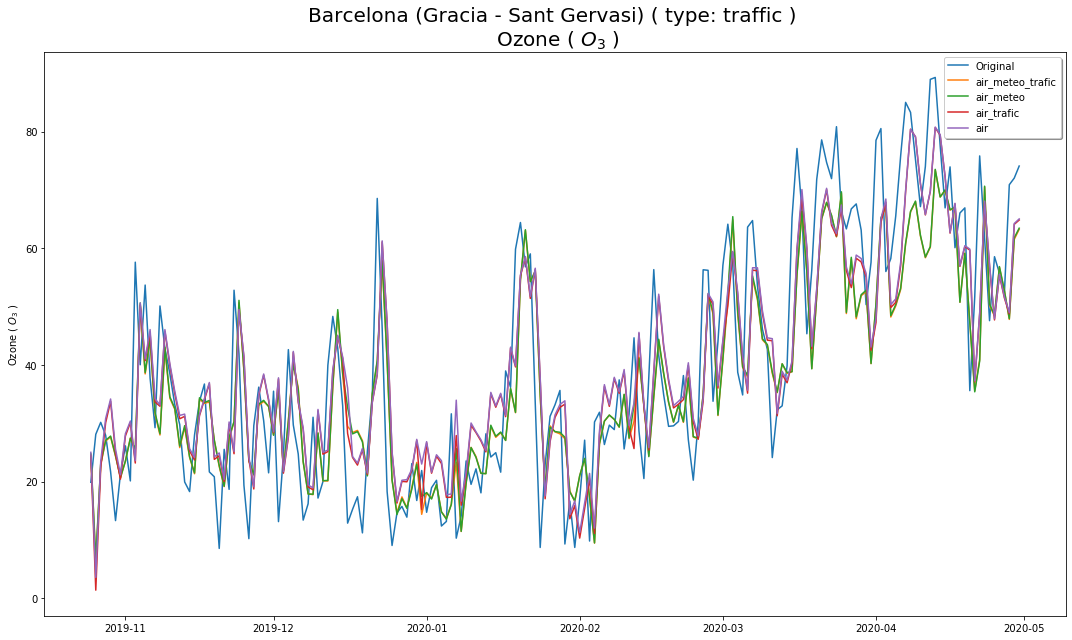

In [79]:
station, output = 8019044, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Para estación parece que sería mejor no incluir los datos de tráfico en la lista de variables independientes, pues no parece que aporten variabilidad en el conjunto de los datos.

In [80]:
show_model_evaluation_stats(stats, title)

La siguiente estación en ser analizada es la de **Parc Vall Hebron**, de tipo **background**.

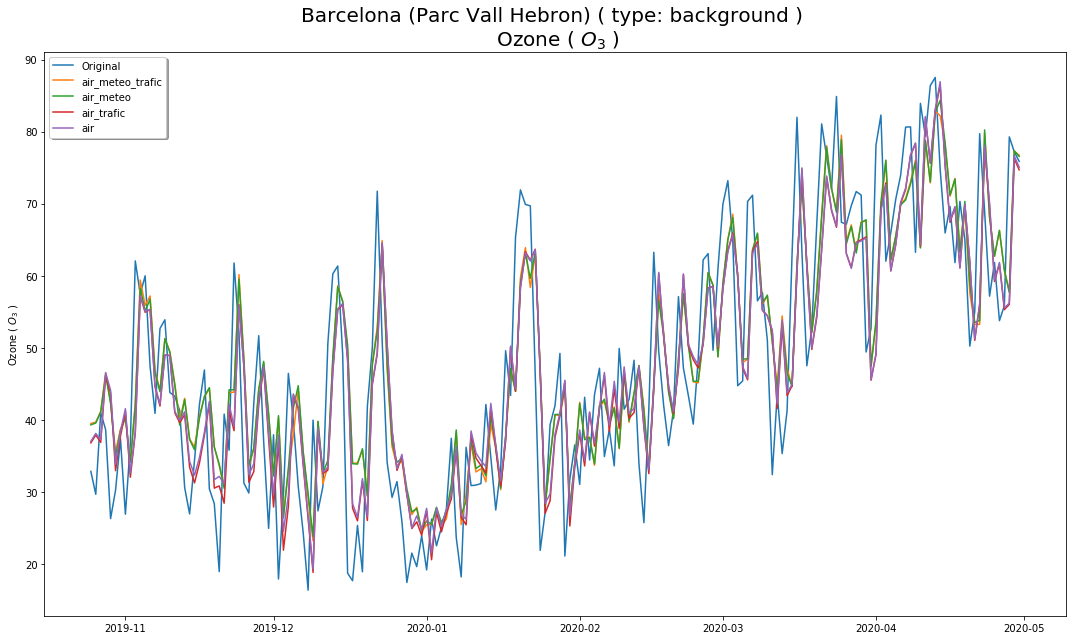

In [81]:
station, output = 8019054, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Como vemos, en la tabla siguiente, se vuelve a repetir la excasa influencia de los datos de tráfico en la predicción para esta estación. 

In [82]:
show_model_evaluation_stats(stats, title)

Terminamos este análisis con los resultados para la estación de **Palau Reial**.

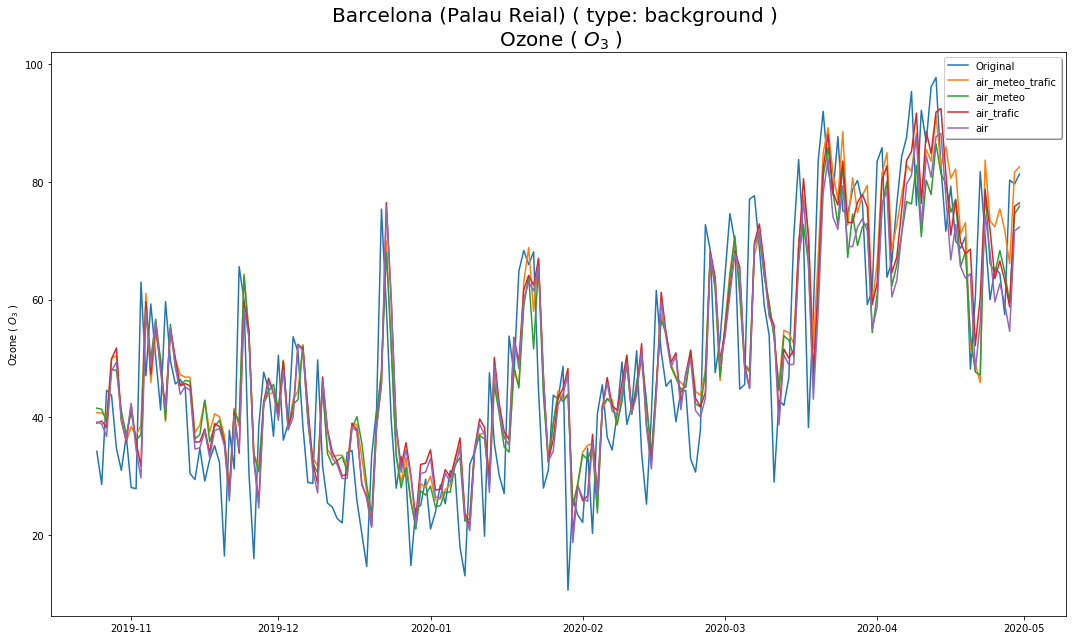

In [83]:
station, output = 8019057, "O3"
subtitle = output_title_dict[output]
title = get_station_title(station, data_air_stations, subtitle)
stats = evaluate_inputs(data_air, data_meteo_hourly, data_trafic, station, output, tuning_data, title, subtitle)

Se vuelve a repetir el mismo resultado anterior, constatando la baja influencia de los datos de tráfico en la predicción del nivel de ozono. Lo cual parece lógico al ser este un gas más influenciado por factores atmosféricos como la radiación solar.

In [84]:
show_model_evaluation_stats(stats, title)

# 6. Conclusiones

Con este estudio creemos haber cumplido con el principal objetivo que nos habíamos marcado al inicio del trabajo, que es: obtener un modelo, de minería de datos, lo suficientemente fiable, que nos permita predecir algunos de los factores contaminantes que definen la calidad del aire en la ciudad de Barcelona. Hemos analizado cinco modelos de minería de datos, basados en técnicas muy diversas. Los modelos que hemos utilizado son: máquina de vectores de soporte (en sus siglas en inglés: $SVM$), modelo de RandomForest ($RF$), modelo de redes neuronales artificiales ($ANN$, del inglés) basado en perceptrón multicapa ($MLP$, del inglés) y modelos de redes neuronales recurrentes, como son $LSTM$ y $GRU$.

Hemos utilizado los distintos modelos para predecir varios de los parámetros de contaminación del aire registrados en las estaciones de observación de calidad del aire de la ciudad de Barcelona. En concreto, hemos construido los modelos para predecir: el nivel de óxido de carbono $CO$ en el aire, el óxido de nitrógeno $NO_x$, el dióxido de nitrógeno $NO_2$ y, el ozono $O_3$. En todos los casos, y para distintas estaciones de topologías distintas, hemos obtenido resultados bastante aceptables.

En la mayoría de los casos, el modelo $GRU$ ha resultado ser el que mejores resultados ofrecía. Muy de cerca le han seguido los modelos de $LSTM$ y $MLP$. Aunque, este último, sufre del problema de la desaparición del gradiente (en inglés, *the vanishing gradient problem*). El cual produce que el modelo de $MLP$ se comporte de forma inestable cuando el número de capas ocultas se incrementa.

Adenás hemos probado distintos métodos de reducción de variables para intentar obtener aquellas variables que más intervienen en la variabilidad de los datos para cada estación.

Por último, hemos analizado la influencia de cada uno de los grupos de datos: de contaminación del aire, meteorológicos y de tráfico; sobre la predicción de los distintos contaminantes del aire en cada una de las estaciones de obervación de calidad del aire. Vemos como la predicción del nivel de ozono $O_3$ solamente se ve influenciada por factores meteorológicos, y otros contaminantes, y no por los datos de tráfico en cualquiera de las estaciones. Para los demás contaminantes, vemos que la influencia del tráfico en las predicciones depende, seguramente, por la variabilidad de estos datos en cada una de las estaciones. Así, en estaciones con poco volumen de tráfico, o sin congestión, parece no aconsejable incluir los datos de tráfico para predecir los contaminantes del aire. Sin embargo, en aquellas estaciones que sí presentan mayor volumen de tráfico, la inclusión de los datos de tráfico puede influir en la mejora de los resultados de nuestros modelos de predicción.

# Bibliografía

- Pandas documentation: [Styling](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)

- Gironés J, Casas J, Minguillón J, Caihuelas R. Minería de datos - modelos y algoritmos. Primera edición ed.: Editorial UOC; 2017.

- Wikipedia. Multilayer perceptron. https://en.wikipedia.org/wiki/Multilayer_perceptron

- Wikipedia. Long short-term memory. https://en.wikipedia.org/wiki/Long_short-term_memory

- Wikipedia. Gated recurrent unit. https://en.wikipedia.org/wiki/Gated_recurrent_unit
 